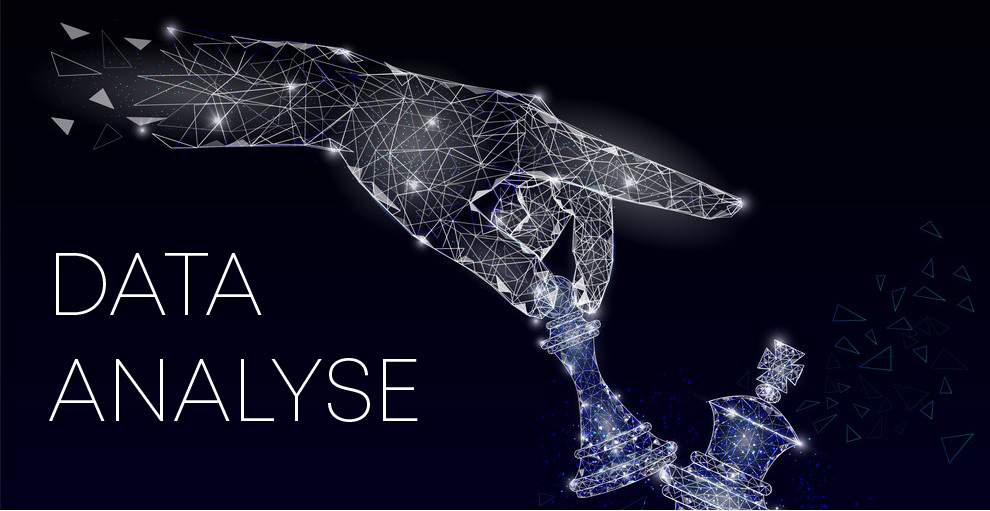
#### source : https://blog.mbadmb.com/tout-savoir-sur-le-metier-de-data-analyst/data-analyse-strategy/

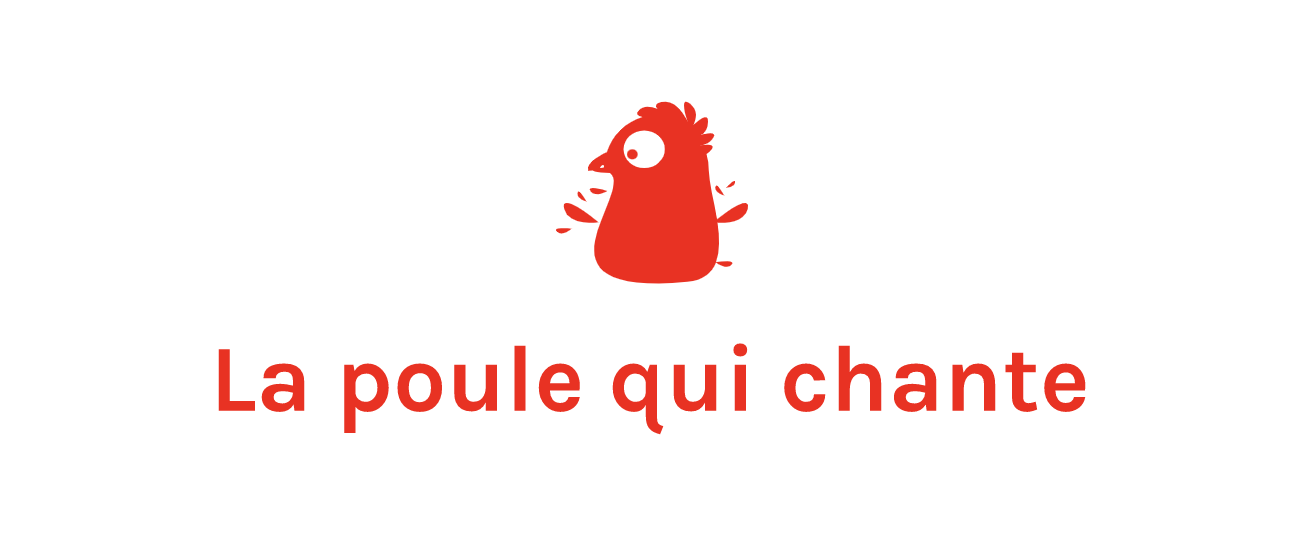

## - NoteBook 2 -
---
### 1 - Test de Classification Ascendante Hi√©rarchique avec dendrogramme.
### 2 - M√©thode des K-MEANS.
### 3 - Comparaison des deux m√©thodes de clustering.
### 4 - Analyse du centro√Øde des classes.
### 5 - Analyse en Composantes Principales.
### 6 - Synth√®se de compr√©hension (groupes, liens entre les variables, liens entre les individus).
### 7 - Heatmap avec croisements entre clusters de pays et les diff√©rentes variables (image).
### 8 - Synth√®se finale sur les groupes choisis.

---

In [1]:
pip install sklearn.inspection

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.inspection (from versions: none)
ERROR: No matching distribution found for sklearn.inspection


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

# libraire CAH :
from scipy.cluster.hierarchy import dendrogram, linkage

# libraire silhouette score :
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error

# Import Libraries
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools

In [3]:
# Lecture des donn√©es :
dispo_alim_complet = pd.read_csv('dispo_alim_complet.csv', sep = ",", header = 0)

In [4]:
# On mets la variable "zone" en index :
dispo_alim_complet = dispo_alim_complet.set_index("zone")

In [5]:
# Suppression des Nans :
dispo_alim_complet = dispo_alim_complet.fillna(0)

In [6]:
dispo_alim_complet.shape # DataFrame avec conservation de toutes les colonnes

(172, 18)

In [7]:
# Apr√®s v√©rification nous avons 2 pays de plus dans dispo_alim_complet car nous gardons toutes les variables mais 
# ces 2 pays n'importent pas de poulet.

# Supprimons les afin d'√©viter les probl√®mes d'indexation sans liens :
dispo_alim_complet = dispo_alim_complet.loc[(dispo_alim_complet.index != "R√©publique d√©mocratique populaire lao") &
                                            (dispo_alim_complet.index != "Ouzb√©kistan"), :]

In [8]:
dispo_alim_complet.shape

(170, 18)

---

# üöÄ LES CRIT√àRES D'UN BON ALGO DE CLUSTERING :

#### 3 familles de crit√®res permettent d'√©valuer si le r√©sultat d'un algorithme de clustering est satisfaisant :
### Ces 3 familles sont bas√©es sur : 
#### üïµÔ∏è‚Äç‚ôÇÔ∏è Forme des clusters
#### üïµÔ∏è‚Äç Stabilit√© des clusters (beaucoup d'algo non d√©terministes, diff√©rents r√©sultats √† chaque it√©ration)
#### üïµÔ∏è‚Äç Compatibilit√© avec des connaissances sp√©cifiques au domaine

---
---
---

# Pr√©-analyses :

#### Apr√®s un premier cycle d'analyse et de r√©glages voici les constatations et la poursuite d'analyse.
#### La population biaisaient les r√©sultats du clustering car sa variance est extr√™me.
#### Mise en place d'une fonction logarithmique pour d√©samplifier l'impact de sa variation. (Sinon cela conduit √† des r√©sultats plut√¥t orient√©s volume de population alors que notre objectif est "importation de poulet")

In [9]:
dispo_alim_complet['population_en_milliers'] = np.log(dispo_alim_complet['population_en_milliers'])

---

# Classifications Ascendantes Hi√©rarchiques :

---

## 1 - CAH sur toutes nos variables en m√™me temps :

---

### Analyse dendrographiques dans diff√©rentes m√©triques :

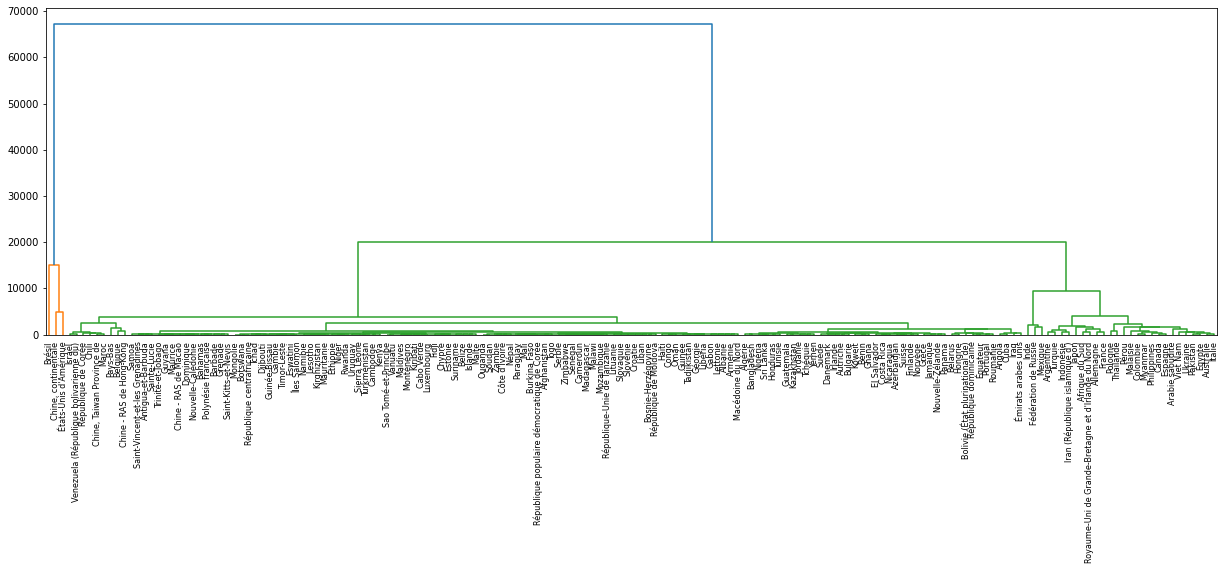

In [10]:
# Calcul de la distance entre chaque individu avec scipy :
Z = linkage(dispo_alim_complet, 'ward')

# Affichage de notre dendrogramme :
plt.figure(figsize=(21,6)) # figsize=(21,16) pour afficher le diagramme plus grand
dendrogram(Z,leaf_rotation = 90,
           leaf_font_size = 8, # modifiable si on veut changer la taille d'√©criture des pays
           labels = dispo_alim_complet.index # nom des colonnes 
          )
plt.show()

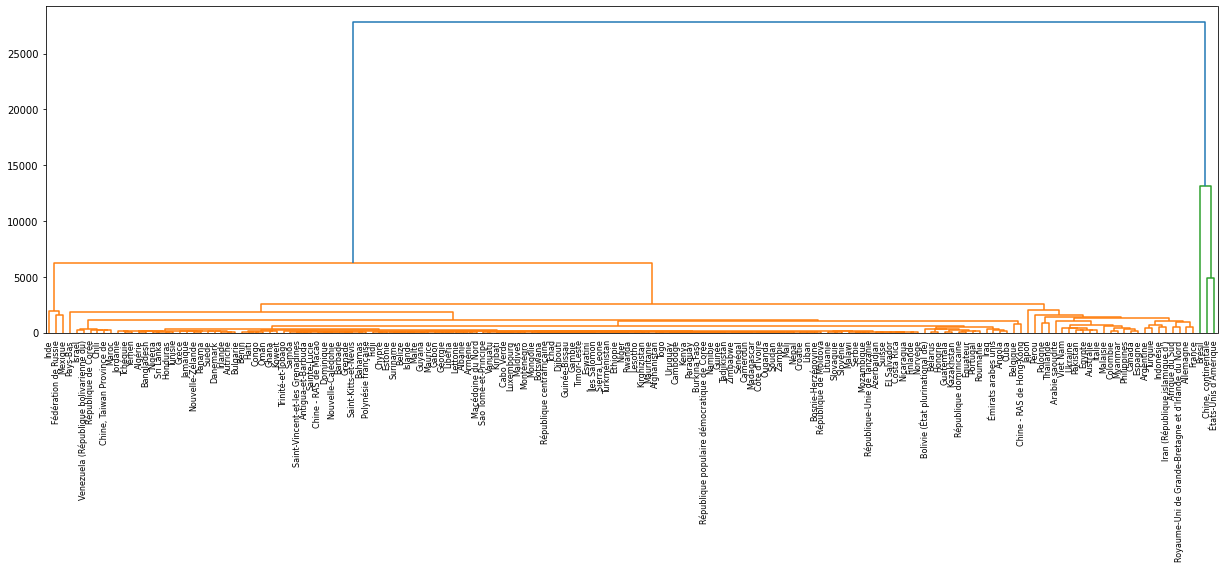

In [11]:
# Calcul de la distance entre chaque individu avec scipy :
Z = linkage(dispo_alim_complet, 'average')

# Affichage de notre dendrogramme :
plt.figure(figsize=(21,6)) # figsize=(21,16) pour afficher le diagramme plus grand
dendrogram(Z,leaf_rotation = 90,
           leaf_font_size = 8, # modifiable si on veut changer la taille d'√©criture des pays
           labels = dispo_alim_complet.index # nom des colonnes
          )
plt.show()

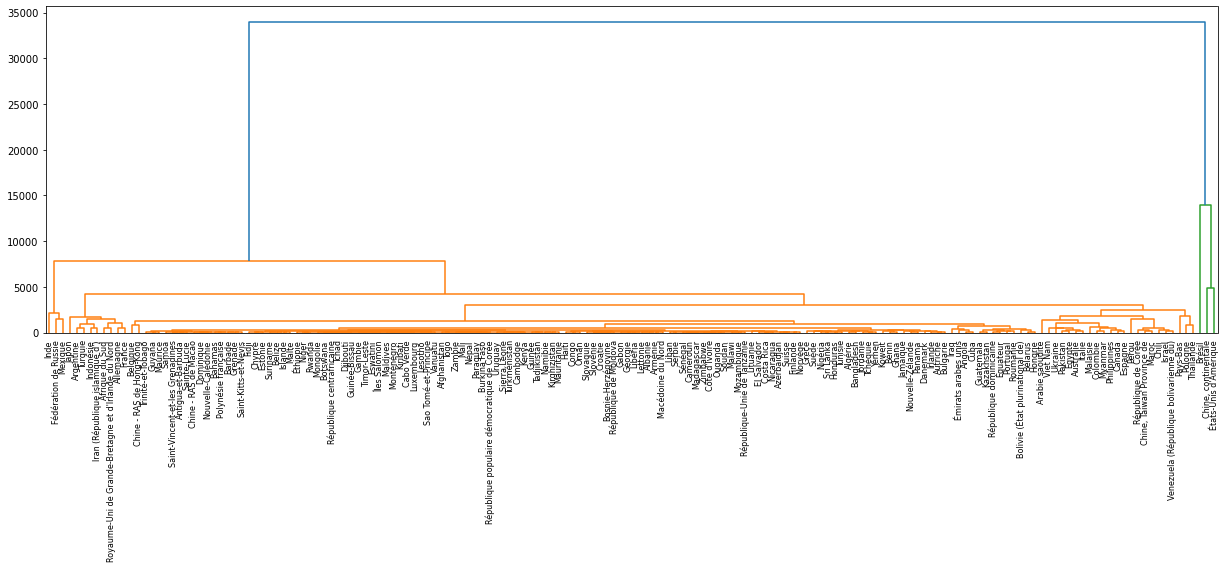

In [12]:
# Calcul de la distance entre chaque individu avec scipy :
Z = linkage(dispo_alim_complet, 'complete')

# Affichage de notre dendrogramme :
plt.figure(figsize=(21,6)) # figsize=(21,16) pour afficher le diagramme plus grand
dendrogram(Z,leaf_rotation = 90,
           leaf_font_size = 8, # modifiable si on veut changer la taille d'√©criture des pays
           labels = dispo_alim_complet.index # nom des colonnes 
          )
plt.show()

# Observations :
## 2 clusters principaux orange et vert.
## Avec la distance de ward 3 ou 5 clusters permettent une belle descente dans la p√©cision.

---
---

# 1.1- Contr√¥le de silhouette du clustering via la m√©thode KMEANS :

---

### üéØ Le coefficient de silhouette est calcul√© √† l'aide de la distance moyenne intra-grappe et de la distance moyenne de la grappe la plus proche pour chaque √©chantillon.

#### üìå La meilleure valeur est 1 et la pire valeur est -1.
#### üìå Les valeurs proches de 0 indiquent des clusters qui se chevauchent.
#### üìå Les valeurs n√©gatives indiquent g√©n√©ralement un √©chantillon affect√© au mauvais groupe, car un groupe diff√©rent est plus similaire.

---

[0.9507022  0.7870982  0.78486938 0.78700381 0.77964442 0.70878442
 0.60965828 0.60641995 0.50057369 0.59780722 0.49667948 0.49121761
 0.50094177 0.49210476 0.49311296]


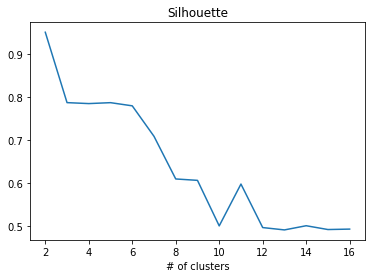

In [13]:
# Test du nombre de clusters avec la m√©trique silouhette :

res = np.arange(15, dtype = "double")
for k in np.arange(15):
    km = KMeans(n_clusters = k + 2)
    km.fit(dispo_alim_complet)
    res[k] = metrics.silhouette_score(dispo_alim_complet, km.labels_)
print(res)

# Affichage graphique :

plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2, 17, 1), res)
plt.show()

#### pour k = 2 nous avons 0.9507022 de silhouette.
#### pour k = 3 nous avons 0.7870982 de silhouette.
### üìå 2 √† 3 clusters conservent un maximum de silhouette.

---

# Analyses bas√©es sur la m√©thode Elbow : 

## M√©thode d√Æte "du coude" :

C:\Users\cyril\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


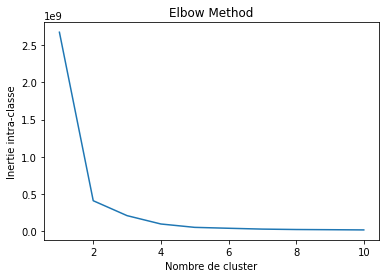

In [14]:
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(dispo_alim_complet)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Nombre de cluster')
plt.ylabel('Inertie intra-classe')
plt.show()

### R√©sultats :
#### Zone optimale 3 clusters.

### Observation :
#### Les diff√©rentes m√©thodes employ√©es convergent vers les m√™mes r√©sultats, nous avons trouv√© un nombre de clusters stable et fiable.

---
---
---

# Lan√ßons une pr√©diction pour voir √† quel cluster chaque pays est rattach√© :

In [15]:
X = dispo_alim_complet

model = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
model.fit(X)

KMeans(n_clusters=3, random_state=0)

### Pr√©diction des clusters pour chacun de nos pays :

In [16]:
model.predict(X)

array([0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0])

In [17]:
# Mise en DataFrame des clusters affili√©s pour exploitation graphique :

y_cluster_predict_kmean = model.predict(X)
X_with_clusters = X
X_with_clusters["cluster"] = y_cluster_predict_kmean
X_with_clusters

Alimentation pour touristes  Aliments pour animaux  \
zone                                                                        
Afghanistan                                    0.0                    0.0   
Afrique du Sud                                 0.0                    0.0   
Albanie                                        0.0                    0.0   
Alg√©rie                                        0.0                    0.0   
Allemagne                                      0.0                    0.0   
...                                            ...                    ...   
√âmirats arabes unis                            0.0                    0.0   
√âquateur                                       0.0                    0.0   
√âtats-Unis d'Am√©rique                          0.0                    0.0   
√âthiopie                                       0.0                    0.0   
√éles Salomon                                   0.0                    0.0   

                       Autres utilisations (non alimentaire)  \
zone                                                           
Afghanistan                                              0.0   
Afrique du Sud                                           0.0   
Albanie                                                  0.0   
Alg√©rie                                                  0.0   
Allemagne                                                0.0   
...                                                      ...   
√âmirats arabes unis                                      0.0   
√âquateur                                                 0.0   
√âtats-Unis d'Am√©rique                                   89.0   
√âthiopie                                                 0.0   
√éles Salomon                                             0.0   

                       Disponibilit√© alimentaire (Kcal/personne/jour)  \
zone                                                                    
Afghanistan                                                       5.0   
Afrique du Sud                                                  143.0   
Albanie                                                          85.0   
Alg√©rie                                                          22.0   
Allemagne                                                        71.0   
...                                                               ...   
√âmirats arabes unis                                             147.0   
√âquateur                                                         83.0   
√âtats-Unis d'Am√©rique                                           219.0   
√âthiopie                                                          0.0   
√éles Salomon                                                     18.0   

                       Disponibilit√© alimentaire en quantit√© (kg/personne/an)  \
zone                                                                            
Afghanistan                                                         1.53        
Afrique du Sud                                                     35.69        
Albanie                                                            16.36        
Alg√©rie                                                             6.38        
Allemagne                                                          19.47        
...                                                                  ...        
√âmirats arabes unis                                                43.47        
√âquateur                                                           19.31        
√âtats-Unis d'Am√©rique                                              55.68        
√âthiopie                                                            0.13        
√éles Salomon                                                        4.45        

                       Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)  \
zone                                                          

In [18]:
X = X.drop(columns=['cluster'])

---

## Intensit√© de la variance de nos variables :

{'whiskers': [<matplotlib.lines.Line2D at 0x120ad7a2520>,
 'caps': [<matplotlib.lines.Line2D at 0x120ad7a2ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x120ad7a2250>,
 'medians': [<matplotlib.lines.Line2D at 0x120ad7ad0a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x120ad7ad370>,
 'means': []}

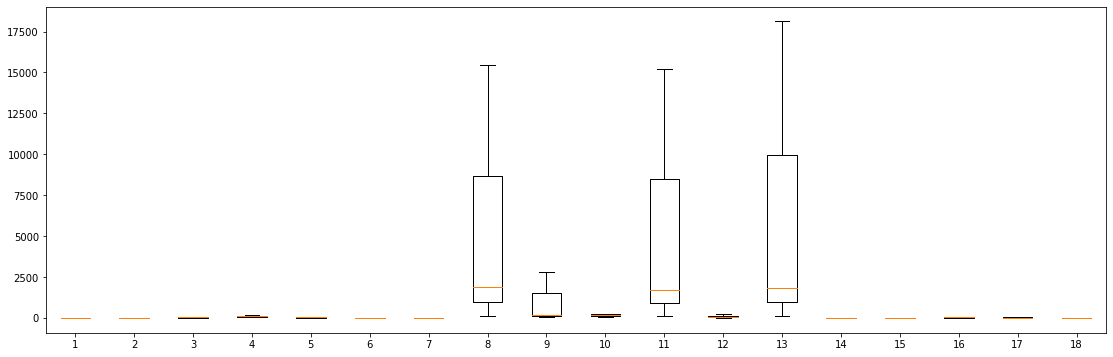

In [19]:
plt.figure(figsize = (19,6))
plt.boxplot(model.cluster_centers_)

# On voit que les variables suivantes sont les plus d√©terministes dans notre classification :
#### 8 (Disponibilit√© int√©rieure)
#### 9 (Exportations - Quantit√©)
#### 11 (Importations - Quantit√©)
#### 13 (Production)

---

## Caract√©risation des clusters selon importation et production :

#### Un cluster diff√©rent par couleurs diff√©rentes :

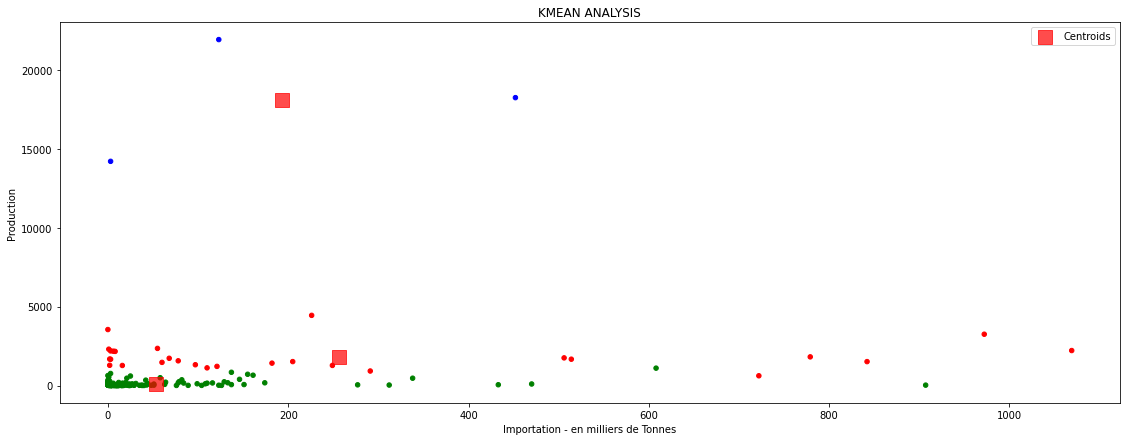

In [20]:
colormap = np.array(["green", "blue", "red"])
plt.figure(figsize = (19, 7))

plt.scatter(X['Importations - Quantit√©'], X['Production'], c = colormap[y_cluster_predict_kmean], s = 20)
plt.scatter(model.cluster_centers_[:, 9], model.cluster_centers_[:, 12],
            s = 200, marker = 's', c = 'red', alpha = 0.7, label = 'Centroids')

plt.title('KMEAN ANALYSIS')
plt.xlabel('Importation - en milliers de Tonnes')
plt.ylabel('Production')
plt.legend()
plt.show()

## Caract√©risation des clusters selon importation et exportation :

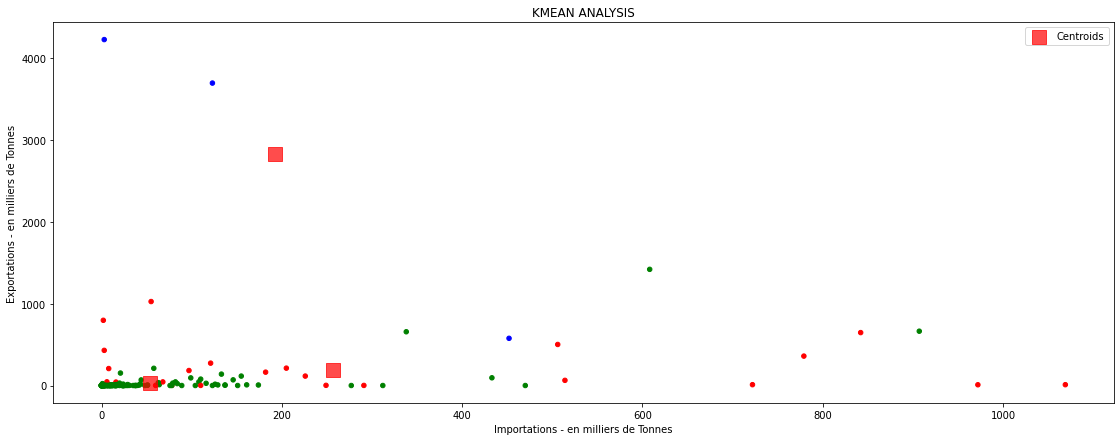

In [21]:
colormap = np.array(["green", "blue", "red"])
plt.figure(figsize = (19, 7))
plt.scatter(X['Importations - Quantit√©'], X['Exportations - Quantit√©'], c = colormap[y_cluster_predict_kmean], s = 20)
plt.scatter(model.cluster_centers_[:, 9], model.cluster_centers_[:, 8],
            s = 200, marker = 's', c = 'red', alpha = 0.7, label = 'Centroids')

plt.title('KMEAN ANALYSIS')
plt.xlabel('Importations - en milliers de Tonnes')
plt.ylabel('Exportations - en milliers de Tonnes')
plt.legend()
plt.show()

## Caract√©risation des clusters selon  exportation et production :

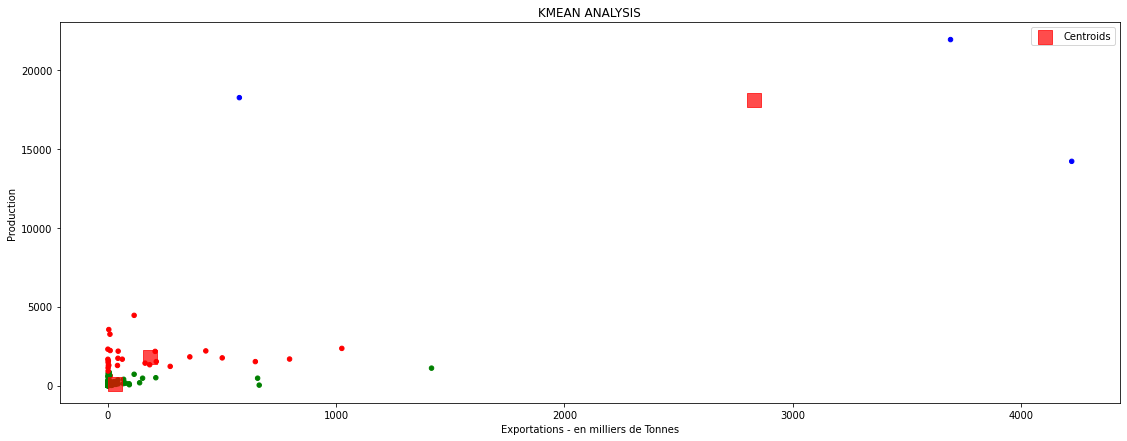

In [22]:
colormap = np.array(["green", "blue", "red"])
plt.figure(figsize = (19, 7))
plt.scatter(X['Exportations - Quantit√©'], X['Production'], c = colormap[y_cluster_predict_kmean], s = 20)
plt.scatter(model.cluster_centers_[:, 8], model.cluster_centers_[:, 12],
            s = 200, marker = 's', c = 'red', alpha = 0.7, label = 'Centroids')

plt.title('KMEAN ANALYSIS')
plt.xlabel('Exportations - en milliers de Tonnes')
plt.ylabel('Production')
plt.legend()
plt.show()

In [23]:
# R√©cup√©ration de la matrice de coordonn√©es des centro√Ødes de nos clusters pour chaque variable :

model.cluster_centers_

array([[ 1.22302158e-01,  0.00000000e+00,  2.21582734e+00,
         6.97697842e+01,  1.90701439e+01,  4.56633094e+00,
         6.69892086e+00,  1.31805755e+02,  3.02661871e+01,
         5.36330935e+01,  1.27446043e+02,  1.81294964e+00,
         1.15690647e+02, -2.21582734e+00,  0.00000000e+00,
         2.38848921e+00,  7.22302158e+00,  8.45434200e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.96666667e+01,
         1.60666667e+02,  3.86800000e+01,  1.16133333e+01,
         1.31900000e+01,  1.54696667e+04,  2.83033333e+03,
         1.92666667e+02,  1.52000000e+04,  2.14333333e+02,
         1.81170000e+04, -3.33333333e-01,  0.00000000e+00,
         2.60000000e+01,  1.00000000e+01,  1.30344074e+01],
       [-2.77555756e-17,  0.00000000e+00,  3.93928571e+01,
         9.27500000e+01,  2.48942857e+01,  6.06285714e+00,
         8.92571429e+00,  1.86289286e+03,  1.83821429e+02,
         2.56678571e+02,  1.72796429e+03,  7.23214286e+01,
         1.83571429e+03, -5.57142857e+00,  0.00000000e

---

## Heatmap de comparaison des clusters :

In [24]:
X_with_clusters.columns
X_with_clusters.fillna(0)

Alimentation pour touristes  Aliments pour animaux  \
zone                                                                        
Afghanistan                                    0.0                    0.0   
Afrique du Sud                                 0.0                    0.0   
Albanie                                        0.0                    0.0   
Alg√©rie                                        0.0                    0.0   
Allemagne                                      0.0                    0.0   
...                                            ...                    ...   
√âmirats arabes unis                            0.0                    0.0   
√âquateur                                       0.0                    0.0   
√âtats-Unis d'Am√©rique                          0.0                    0.0   
√âthiopie                                       0.0                    0.0   
√éles Salomon                                   0.0                    0.0   

                       Autres utilisations (non alimentaire)  \
zone                                                           
Afghanistan                                              0.0   
Afrique du Sud                                           0.0   
Albanie                                                  0.0   
Alg√©rie                                                  0.0   
Allemagne                                                0.0   
...                                                      ...   
√âmirats arabes unis                                      0.0   
√âquateur                                                 0.0   
√âtats-Unis d'Am√©rique                                   89.0   
√âthiopie                                                 0.0   
√éles Salomon                                             0.0   

                       Disponibilit√© alimentaire (Kcal/personne/jour)  \
zone                                                                    
Afghanistan                                                       5.0   
Afrique du Sud                                                  143.0   
Albanie                                                          85.0   
Alg√©rie                                                          22.0   
Allemagne                                                        71.0   
...                                                               ...   
√âmirats arabes unis                                             147.0   
√âquateur                                                         83.0   
√âtats-Unis d'Am√©rique                                           219.0   
√âthiopie                                                          0.0   
√éles Salomon                                                     18.0   

                       Disponibilit√© alimentaire en quantit√© (kg/personne/an)  \
zone                                                                            
Afghanistan                                                         1.53        
Afrique du Sud                                                     35.69        
Albanie                                                            16.36        
Alg√©rie                                                             6.38        
Allemagne                                                          19.47        
...                                                                  ...        
√âmirats arabes unis                                                43.47        
√âquateur                                                           19.31        
√âtats-Unis d'Am√©rique                                              55.68        
√âthiopie                                                            0.13        
√éles Salomon                                                        4.45        

                       Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)  \
zone                                                          

## Appairement des variables et caract√©risation des clusters :

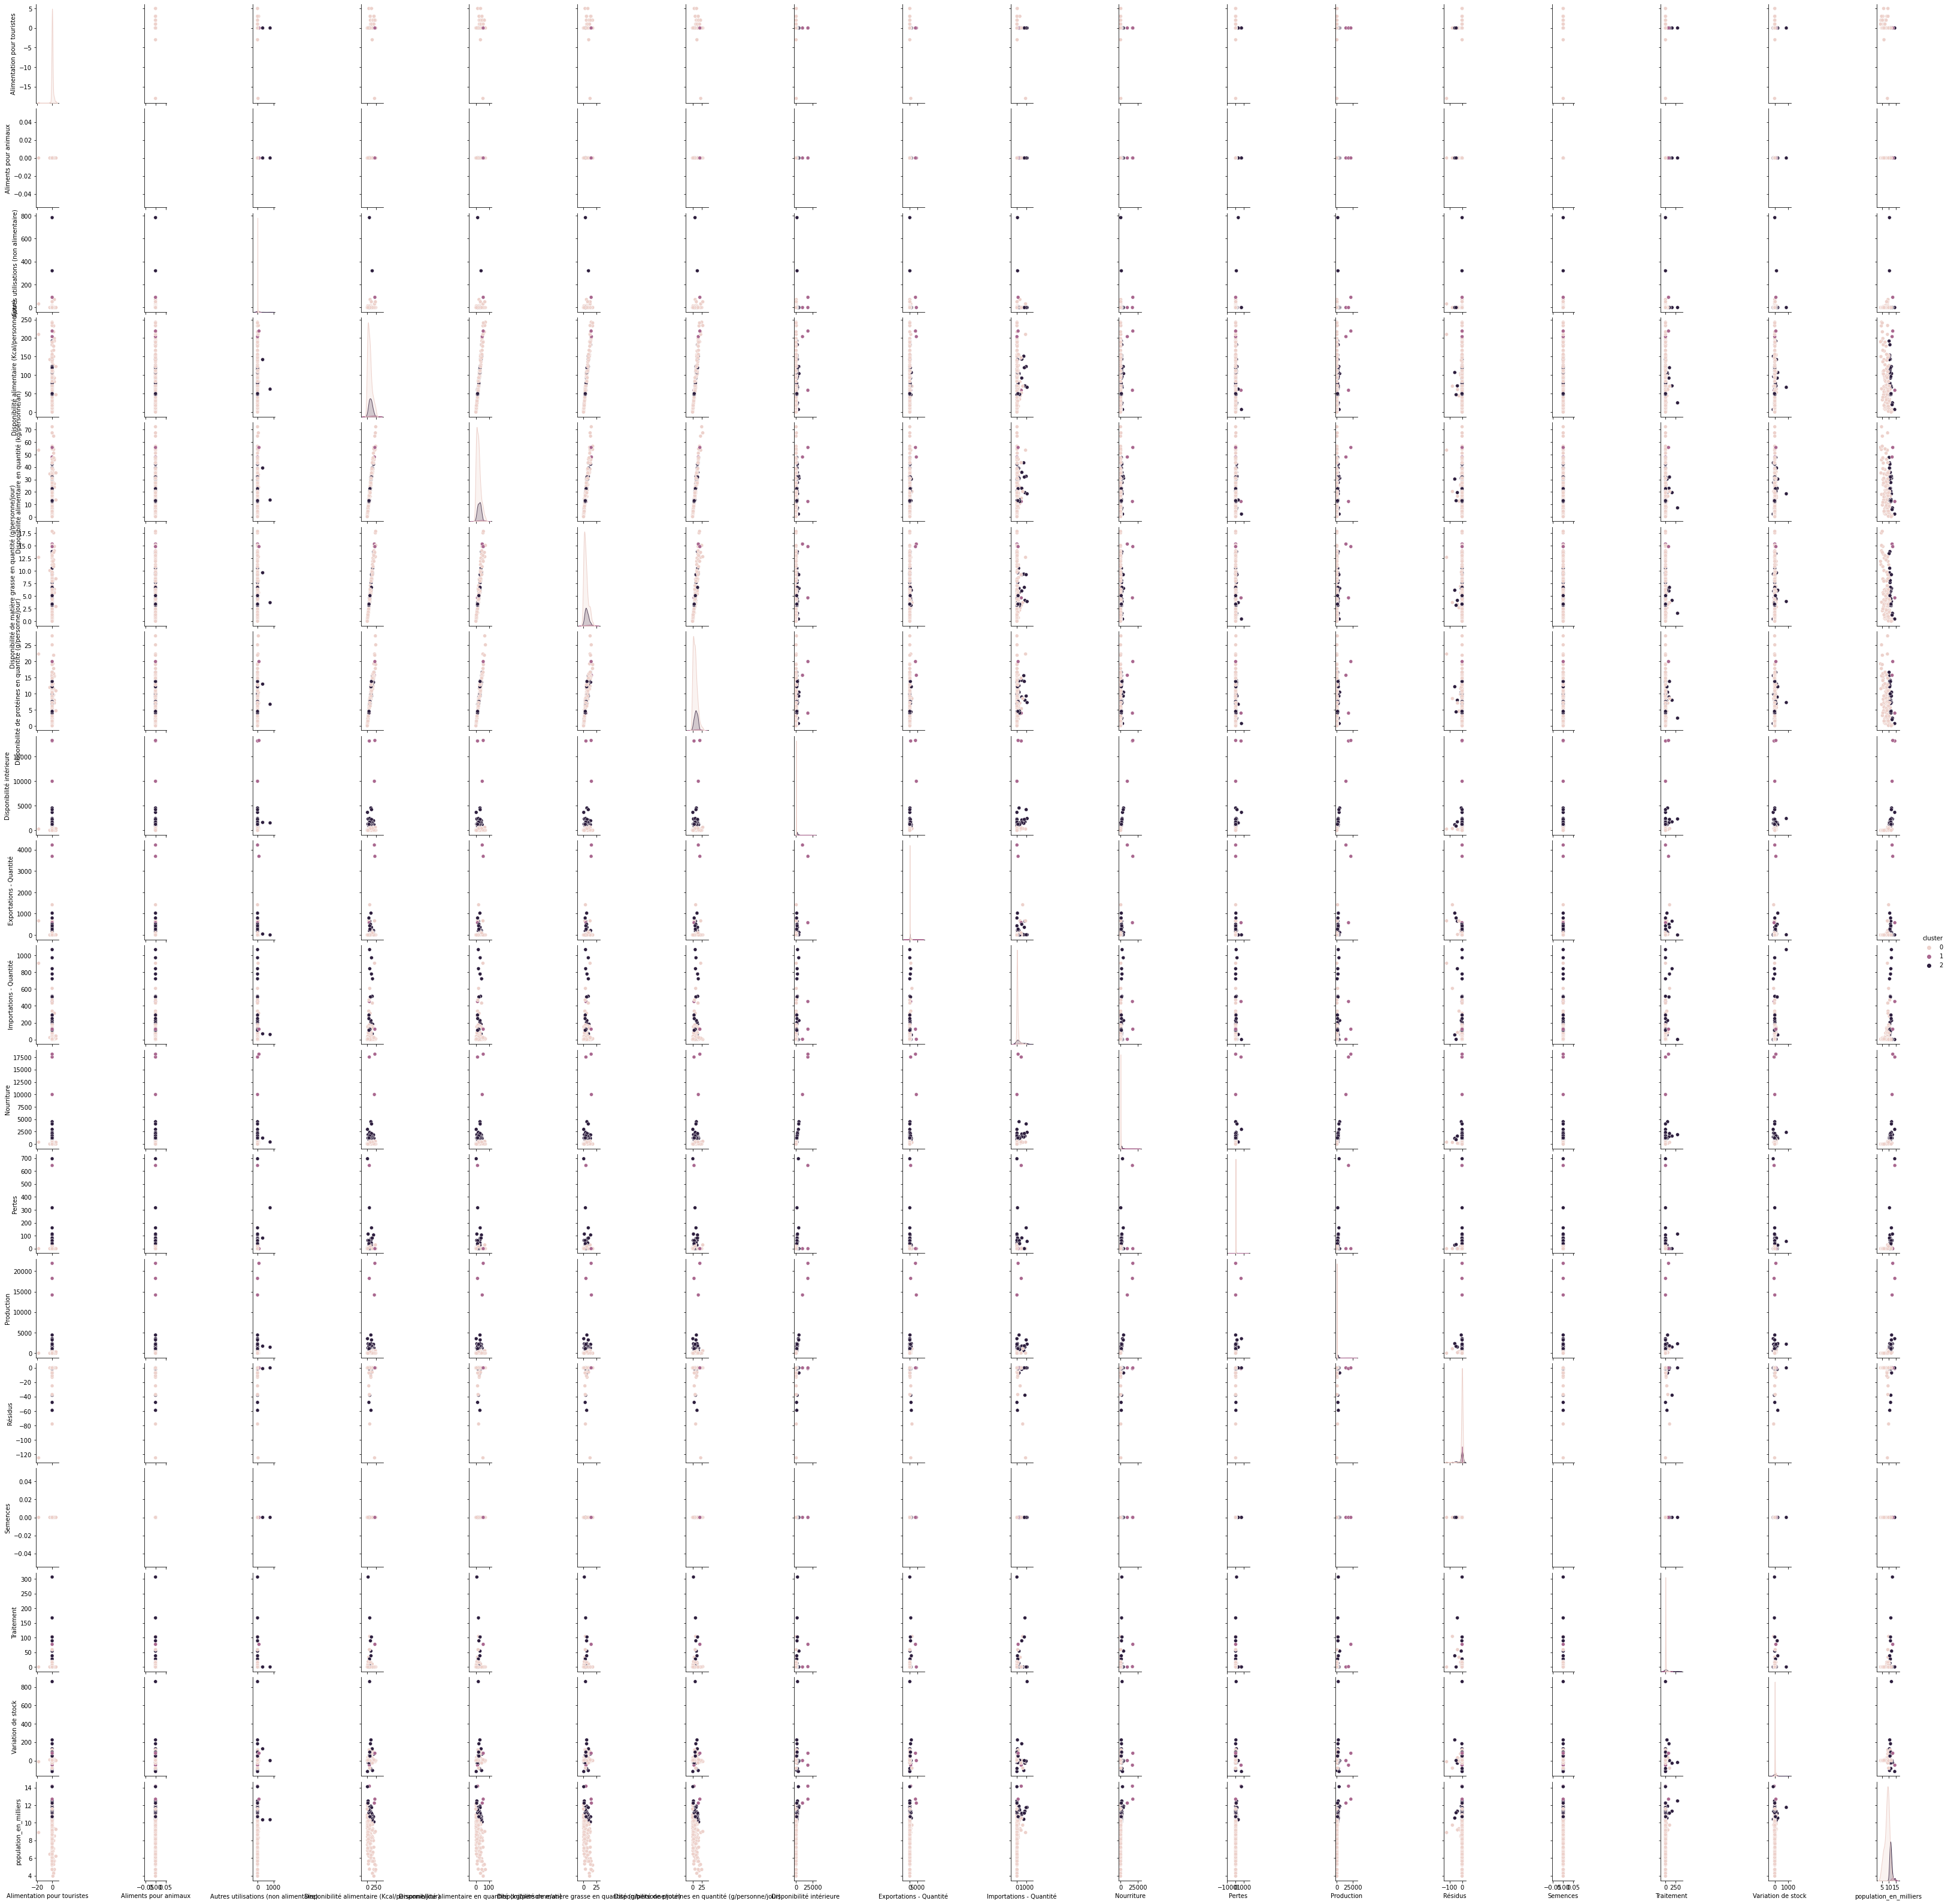

In [25]:
sns.pairplot(X_with_clusters, hue="cluster")

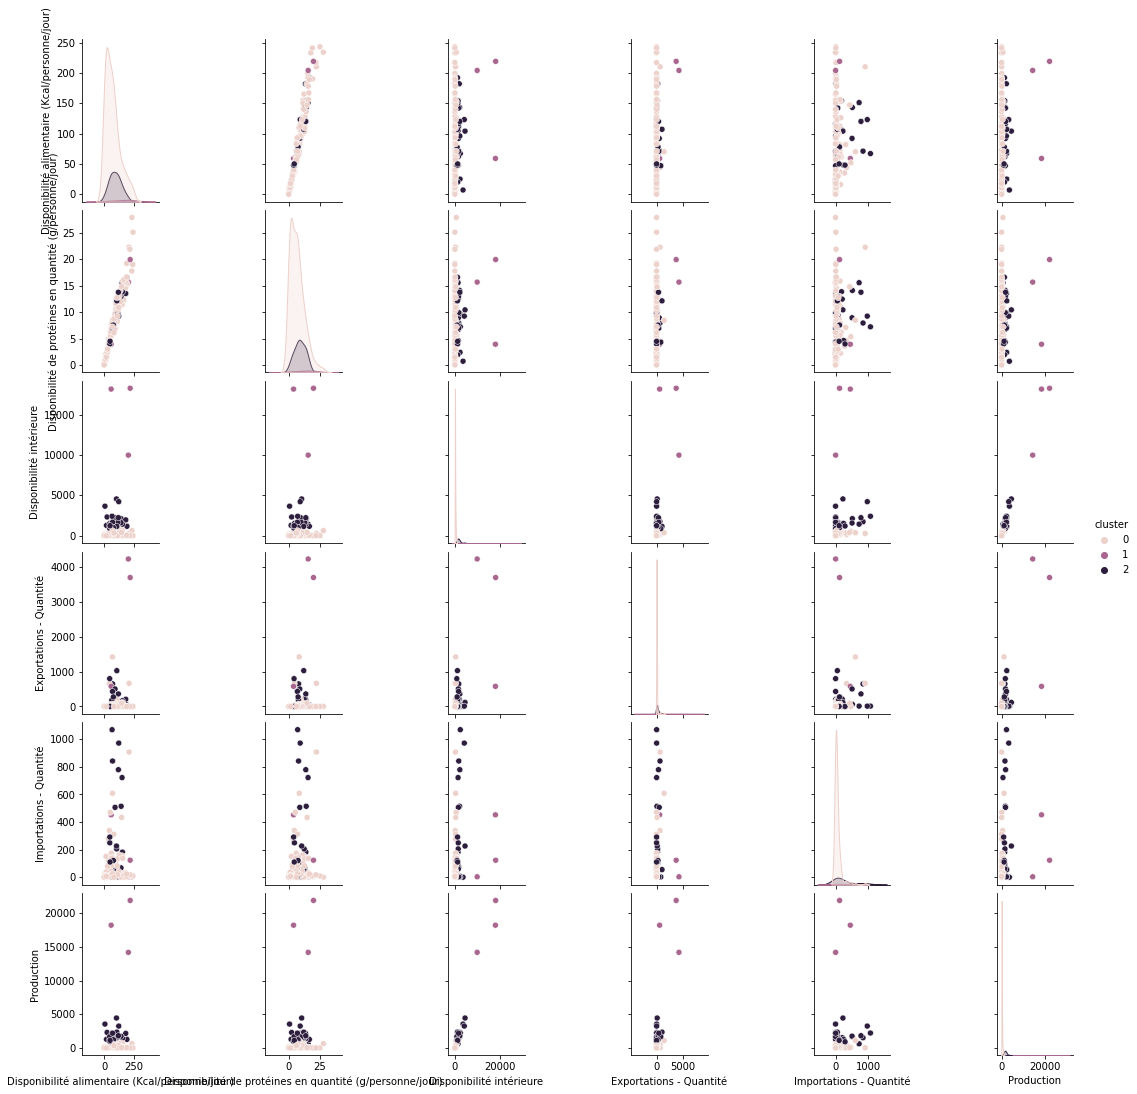

In [26]:
X_best_features_with_cluster = X_with_clusters.drop(columns=[
    "Alimentation pour touristes","Aliments pour animaux",
    "Autres utilisations (non alimentaire)",
    "Autres utilisations (non alimentaire)",
    "Disponibilit√© alimentaire en quantit√© (kg/personne/an)",
    "Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)",
    "Nourriture","Pertes","R√©sidus","Semences","Traitement","Variation de stock",
    "population_en_milliers"])
sns.pairplot(X_best_features_with_cluster, hue="cluster")

---
---
---

# Observations :
## Apr√®s une petite inspection rapide on distingue facilement nos 3 clusters.
## On peut aussi se rendre compte de l'importance de la relativit√© Production/Importations sur le classement des pays dans chaque cluster.
## On distingue donc 3 clusters principaux avec des tendances sp√©cifiques :
## Le cluster 1 : pays produisant peu ou pas produit "volaille", plut√¥t importateurs mais c'est le cluster avec en g√©n√©ral les plus petits importateurs.
## Le cluster 2 : pays grossistes en production de produit "volaille", ils sont tr√®s gros producteurs et tous importateurs sauf le Br√©sil concentr√© sur l'exportation.
## Le cluster 3 : Pays producteurs de produits volaille, ils en importent cependant aussi. Ce cluster contient les plus gros importateurs et la moyenne des importation des pays de ce cluster est la plus grande.

---
---

# Comparaison des diff√©rentes m√©thodes de clustering :

# Nos m√©thodes de clustering convergent :
#### La CAH comme l'analyse KMEAN nous isolent un nombre de clusters similaires comme r√©ellement r√©v√©lateurs.
#### En √©tudiant plus en profondeur la composition des clusters on se rend compte que les regroupements sont similaires, 
#### (exemple de cluster similaire : Br√©sil, Chine Continental et √âtats-Unis d'Am√©rique)
---

---
---
---

---

# Analyses en Composantes Principales :

## Objectif de l'ACP : Trouver k nouvelles variables combinaisons lin√©aires des p variables initiales qui synth√©tisent les variables initiales et font en sorte de perdre le moins d'informations que possible.
#### Tr√®s simplement, peut-on ignorer de l'information sans perdre en qualit√© de la complexit√©.

---

# 3.1 - Input data & Centrage-R√©duction des valeurs (optionnel)

In [31]:
dispo_alim_complet = dispo_alim_complet.drop(columns=["cluster"])

In [32]:
# Input data 1 :
X = dispo_alim_complet
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [33]:
#Input data 2 :
# Input Data Manuel afin de conserver un DataFrame avec le nom des colonnes :
X = dispo_alim_complet

# Centrage manuelle :
temp = X.sub(X.mean()) # Soustraction de la moyenne de chaque colonne √† chaque valeur : centrer les valeurs

# R√©duction manuelle :
X = temp.div(temp.std()) # Division des valeurs du dataframe par l'√©cart-type de chaque colonne

# On remplace les valeurs manquantes par des z√©ros :
X = X.fillna(0)

In [39]:
X

Alimentation pour touristes  Aliments pour animaux  \
zone                                                                        
Afghanistan                              -0.061605                    0.0   
Afrique du Sud                           -0.061605                    0.0   
Albanie                                  -0.061605                    0.0   
Alg√©rie                                  -0.061605                    0.0   
Allemagne                                -0.061605                    0.0   
...                                            ...                    ...   
√âmirats arabes unis                      -0.061605                    0.0   
√âquateur                                 -0.061605                    0.0   
√âtats-Unis d'Am√©rique                    -0.061605                    0.0   
√âthiopie                                 -0.061605                    0.0   
√éles Salomon                             -0.061605                    0.0   

                       Autres utilisations (non alimentaire)  \
zone                                                           
Afghanistan                                        -0.134956   
Afrique du Sud                                     -0.134956   
Albanie                                            -0.134956   
Alg√©rie                                            -0.134956   
Allemagne                                          -0.134956   
...                                                      ...   
√âmirats arabes unis                                -0.134956   
√âquateur                                           -0.134956   
√âtats-Unis d'Am√©rique                               1.226297   
√âthiopie                                           -0.134956   
√éles Salomon                                       -0.134956   

                       Disponibilit√© alimentaire (Kcal/personne/jour)  \
zone                                                                    
Afghanistan                                                 -1.156933   
Afrique du Sud                                               1.118715   
Albanie                                                      0.162283   
Alg√©rie                                                     -0.876600   
Allemagne                                                   -0.068580   
...                                                               ...   
√âmirats arabes unis                                          1.184676   
√âquateur                                                     0.129303   
√âtats-Unis d'Am√©rique                                        2.371970   
√âthiopie                                                    -1.239384   
√éles Salomon                                                -0.942561   

                       Disponibilit√© alimentaire en quantit√© (kg/personne/an)  \
zone                                                                            
Afghanistan                                                    -1.187115        
Afrique du Sud                                                  0.964693        
Albanie                                                        -0.252943        
Alg√©rie                                                        -0.881603        
Allemagne                                                      -0.057037        
...                                                                  ...        
√âmirats arabes unis                                             1.454772        
√âquateur                                                       -0.067116        
√âtats-Unis d'Am√©rique                                           2.223904        
√âthiopie                                                       -1.275304        
√éles Salomon                                                   -1.003178        

                       Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)  \
zone                                                          

# X_PCA : 1√®re analyse PCA

In [40]:
pca = PCA()
X_pca = pca.fit_transform(X)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X.shape[1])]
X_pca = pd.DataFrame(X_pca, columns = component_names)

features = X.columns
features

Index(['Alimentation pour touristes', 'Aliments pour animaux',
       'Autres utilisations (non alimentaire)',
       'Disponibilit√© alimentaire (Kcal/personne/jour)',
       'Disponibilit√© alimentaire en quantit√© (kg/personne/an)',
       'Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)',
       'Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)',
       'Disponibilit√© int√©rieure', 'Exportations - Quantit√©',
       'Importations - Quantit√©', 'Nourriture', 'Pertes', 'Production',
       'R√©sidus', 'Semences', 'Traitement', 'Variation de stock',
       'population_en_milliers'],
      dtype='object')

In [49]:
# Correlation with Importations - Quantit√© :
X[features].corrwith(X["Importations - Quantit√©"])

Alimentation pour touristes                                     -0.321195
Aliments pour animaux                                                 NaN
Autres utilisations (non alimentaire)                            0.001710
Disponibilit√© alimentaire (Kcal/personne/jour)                   0.171294
Disponibilit√© alimentaire en quantit√© (kg/personne/an)           0.177544
Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)    0.137642
Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)         0.215426
Disponibilit√© int√©rieure                                         0.262413
Exportations - Quantit√©                                          0.159591
Importations - Quantit√©                                          1.000000
Nourriture                                                       0.261816
Pertes                                                           0.149166
Production                                                       0.194355
R√©sidus                 

In [51]:
X_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.972396  1.521131  0.059871 -0.165065 -0.110541 -0.251698  0.062627   
1     2.540248 -0.291910  0.475449  0.783465  0.866671  0.276109 -1.700637   
2    -0.519581 -0.630814 -0.203312 -0.060774 -0.184292 -0.174248 -0.021047   
3    -1.499799  1.267815 -0.086863 -0.067432 -0.153933 -0.229625 -0.023270   
4     2.330622  1.994917  4.456626 -1.498838  0.419450  4.498478 -0.042892   
..         ...       ...       ...       ...       ...       ...       ...   
165   1.687665 -1.816565  0.596481  0.291365  0.417524  0.370698 -1.067056   
166  -0.279354 -0.166332 -0.280295  0.081461 -0.191818 -0.119963 -0.191109   
167  14.788105  6.203765 -3.012613 -3.524696 -1.037790 -1.256759  3.556226   
168  -2.079627  1.823947  0.078841 -0.159679 -0.081634 -0.240895  0.063180   
169  -1.924664  0.399169 -0.251696 -0.284610 -0.438998 -0.386846  0.350028   

          PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0   -0.436553  0.146168  0.063580 -0.030644 -0.062913 -0.015203 -0.003531   
1   -1.088008 -0.651836 -0.071152  0.200117  0.053504 -0.203809 -0.003011   
2    0.150019 -0.015845 -0.183663  0.101980 -0.441672 -0.197594  0.009037   
3   -0.442549  0.377197  0.134298 -0.070953 -0.059810  0.014114  0.000558   
4   -0.087354 -1.466437  0.002306  0.101025 -0.150273 -0.012482 -0.006502   
..        ...       ...       ...       ...       ...       ...       ...   
165 -1.177701 -0.838981 -0.241398  0.325799  0.223465  0.122135  0.002201   
166 -0.337664  0.525044  0.114281 -0.009539 -0.371716 -0.033702 -0.003481   
167 -0.049186 -0.202007 -1.520894 -0.766052  0.198355 -0.000828  0.003181   
168 -0.771991  0.466560  0.241592 -0.083902 -0.074847 -0.021751 -0.005277   
169  0.961626 -0.632066 -0.493106  0.109298 -0.091950 -0.003945 -0.003772   

         PC15      PC16          PC17          PC18  
0    0.000030  0.000002 -3.426143e-18 -3.365201e-22  
1    0.000079  0.000041  4.577873e-16 -3.997157e-21  
2    0.000002  0.000070 -1.314877e-17 -1.334851e-21  
3    0.000018  0.000018 -1.951430e-19 -3.412302e-21  
4   -0.000127 -0.000147 -1.553606e-17  3.145716e-21  
..        ...       ...           ...           ...  
165 -0.000289  0.000107 -1.271097e-17  1.002733e-21  
166  0.000039  0.000023 -4.580633e-18 -4.223977e-22  
167  0.000155 -0.000080  1.494317e-17  1.268895e-22  
168 -0.000080  0.000346 -4.291949e-18 -3.603091e-22  
169  0.000040 -0.000007  9.143164e-18  6.257647e-22  

[170 rows x 18 columns]

---

## Extraction de la matrice de corr√©lation des composantes aux clusters :

In [52]:
X_pca["cluster"] = y_cluster_predict_kmean
X_pca.head(2)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.972396  1.521131  0.059871 -0.165065 -0.110541 -0.251698  0.062627   
1  2.540248 -0.291910  0.475449  0.783465  0.866671  0.276109 -1.700637   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.436553  0.146168  0.063580 -0.030644 -0.062913 -0.015203 -0.003531   
1 -1.088008 -0.651836 -0.071152  0.200117  0.053504 -0.203809 -0.003011   

       PC15      PC16          PC17          PC18  cluster  
0  0.000030  0.000002 -3.426143e-18 -3.365201e-22        0  
1  0.000079  0.000041  4.577873e-16 -3.997157e-21        2

In [53]:
X_pca.groupby('cluster').corr().unstack().iloc[:,:]

PC1                                                              \
         PC1       PC2       PC3       PC4       PC5       PC6       PC7   
cluster                                                                    
0        1.0 -0.866238  0.250498  0.543990 -0.115617  0.181815 -0.504118   
1        1.0 -0.243409  0.053301 -0.615542  0.363541  0.230216  0.659820   
2        1.0 -0.383685  0.300935 -0.034088  0.282741  0.066328 -0.122577   

                                       ...      PC18                      \
              PC8       PC9      PC10  ...       PC9      PC10      PC11   
cluster                                ...                                 
0        0.092100  0.129406  0.154613  ...  0.060280  0.012385 -0.015907   
1       -0.335027  0.692952 -0.739334  ... -0.987846  0.181913 -0.421000   
2       -0.034681 -0.304111 -0.126912  ... -0.286437 -0.018269  0.125371   

                                                                          
             PC12      PC13      PC14      PC15      PC16      PC17 PC18  
cluster                                                                   
0       -0.001805 -0.013931  0.016314  0.013659  0.001690  0.389498  1.0  
1       -0.526165 -0.768882 -0.818693 -0.743237  0.614868 -0.989660  1.0  
2        0.028743  0.204503 -0.197347 -0.304138 -0.114948 -0.691874  1.0  

[3 rows x 324 columns]

In [54]:
X_pca.groupby

<bound method DataFrame.groupby of            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.972396  1.521131  0.059871 -0.165065 -0.110541 -0.251698  0.062627   
1     2.540248 -0.291910  0.475449  0.783465  0.866671  0.276109 -1.700637   
2    -0.519581 -0.630814 -0.203312 -0.060774 -0.184292 -0.174248 -0.021047   
3    -1.499799  1.267815 -0.086863 -0.067432 -0.153933 -0.229625 -0.023270   
4     2.330622  1.994917  4.456626 -1.498838  0.419450  4.498478 -0.042892   
..         ...       ...       ...       ...       ...       ...       ...   
165   1.687665 -1.816565  0.596481  0.291365  0.417524  0.370698 -1.067056   
166  -0.279354 -0.166332 -0.280295  0.081461 -0.191818 -0.119963 -0.191109   
167  14.788105  6.203765 -3.012613 -3.524696 -1.037790 -1.256759  3.556226   
168  -2.079627  1.823947  0.078841 -0.159679 -0.081634 -0.240895  0.063180   
169  -1.924664  0.399169 -0.251696 -0.284610 -0.438998 -0.386846  0.350028   

          PC8       PC9     

<AxesSubplot:xlabel='None-None', ylabel='cluster'>

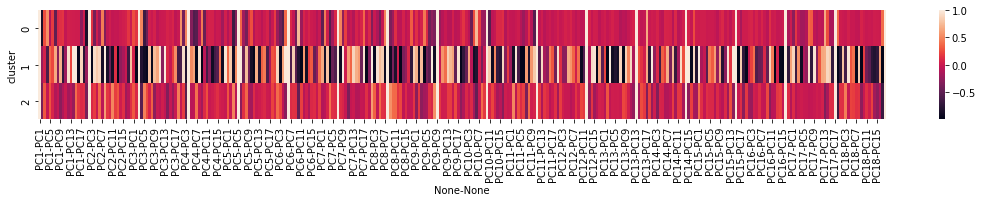

In [55]:
plt.figure(figsize=(19,2))
sns.heatmap(X_pca.groupby('cluster').corr().unstack())

<AxesSubplot:>

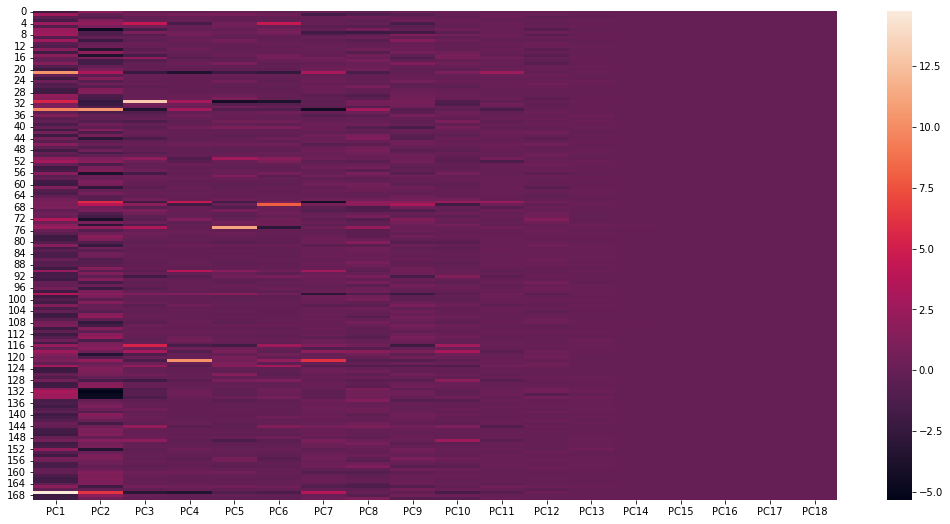

In [56]:
plt.figure(figsize=(18,9))
sns.heatmap(X_pca.drop(columns=["cluster"]))

# 3.2 - R√©aliser l'ACP (numpy)

In [57]:
mypca = PCA(n_components = 18) # On √©value ici toutes les composantes

# Mod√®le d'ACP
mypca.fit(X)

# Pourcentage de la variance expliqu√©e par chacune des composantes s√©lectionn√©es :

print("Valeurs de variance :", mypca.singular_values_)
print("Pourcentages :", mypca.explained_variance_ratio_)

Valeurs de variance : [2.87000365e+01 2.47530110e+01 1.82646631e+01 1.43331341e+01
 1.39449587e+01 1.25509280e+01 1.17765020e+01 8.78604011e+00
 8.18235741e+00 7.63336278e+00 4.72335827e+00 3.46522598e+00
 1.07285232e+00 5.83797147e-02 2.57792841e-03 1.78651507e-03
 4.85285166e-16 4.15884063e-20]
Pourcentages : [3.04619857e-01 2.26594510e-01 1.23372011e-01 7.59758626e-02
 7.19163733e-02 5.82565803e-02 5.12892009e-02 2.85482621e-02
 2.47599752e-02 2.15489006e-02 8.25078158e-03 4.44075115e-03
 4.25670154e-04 1.26042570e-06 2.45773480e-09 1.18033879e-09
 8.70938210e-35 6.39643320e-43]


In [58]:
# Axes principaux dans l'espace des caract√©ristiques, repr√©sentant les directions de la variance maximale dans les donn√©es.
# Les composantes sont tri√©es par variance expliqu√©e.

print(mypca.components_)

[[-5.76577694e-02 -0.00000000e+00  5.88874389e-02  3.34389181e-01
   3.24416449e-01  3.30805927e-01  3.24924944e-01  3.54058636e-01
   3.16005400e-01  1.78399622e-01  3.54835052e-01  1.35801217e-01
   3.58017511e-01 -1.03331289e-01 -0.00000000e+00  1.05088190e-01
   5.40438053e-02  8.32197089e-02]
 [-3.45141824e-02  1.38777878e-17  3.94736640e-02 -3.47744784e-01
  -3.56803336e-01 -3.36699531e-01 -3.48796244e-01  2.91771576e-01
   1.63581112e-01  7.85175259e-02  2.86254508e-01  2.54956953e-01
   2.81250088e-01  2.62563291e-03 -3.08148791e-33  1.29813704e-01
   1.16759083e-02  3.91017384e-01]
 [-5.35538999e-01 -1.11022302e-16 -5.37661965e-02 -3.14699786e-02
  -2.56308991e-02 -6.62650760e-02  2.41465175e-02 -1.52358249e-01
   2.52262995e-02  4.28800630e-01 -1.48600283e-01 -1.31803959e-01
  -1.57595133e-01 -5.92089460e-01 -0.00000000e+00  2.23165055e-01
   1.27711049e-01  1.22446484e-01]
 [-1.84104637e-01 -3.46944695e-17  6.83450638e-01  4.34081197e-02
   3.79854704e-02  3.50606995e-02  5.

In [59]:
# R√©sultats de l'ACP

data_sortie = mypca.fit_transform(X)
data_sortie

array([[-1.97239620e+00,  1.52113052e+00,  5.98708923e-02, ...,
         2.43961336e-06, -3.42614316e-18, -3.36520062e-22],
       [ 2.54024802e+00, -2.91910458e-01,  4.75449405e-01, ...,
         4.09936283e-05,  4.57787251e-16, -3.99715680e-21],
       [-5.19581106e-01, -6.30814171e-01, -2.03312460e-01, ...,
         7.04675936e-05, -1.31487714e-17, -1.33485071e-21],
       ...,
       [ 1.47881050e+01,  6.20376492e+00, -3.01261329e+00, ...,
        -8.00796710e-05,  1.49431743e-17,  1.26889492e-22],
       [-2.07962674e+00,  1.82394701e+00,  7.88414498e-02, ...,
         3.45510347e-04, -4.29194880e-18, -3.60309081e-22],
       [-1.92466361e+00,  3.99169414e-01, -2.51696377e-01, ...,
        -7.03804664e-06,  9.14316425e-18,  6.25764656e-22]])

In [55]:
# Bruit estim√© li√© √† la covariance

print(mypca.noise_variance_)

0.0


# 3.3 - ACP et contr√¥le via diagramme de pareto :

In [56]:
# Initialiser et computer l'ACP :
pca = PCA()
X_pca = pca.fit_transform(X)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

# Obtenir les informations de base :
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1
df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance

# Affichage de la variance expliqu√©e :
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

PCA Overview
Total: 18 components
----------------------------------------
Mean explained variance: 0.056
----------------------------------------
    explained variance  cumulative
1         3.046199e-01    0.304620
2         2.265945e-01    0.531214
3         1.233720e-01    0.654586
4         7.597586e-02    0.730562
5         7.191637e-02    0.802479
6         5.825658e-02    0.860735
7         5.128920e-02    0.912024
8         2.854826e-02    0.940573
9         2.475998e-02    0.965333
10        2.154890e-02    0.986882
11        8.250782e-03    0.995132
12        4.440751e-03    0.999573
13        4.256702e-04    0.999999
14        1.260426e-06    1.000000
15        2.457735e-09    1.000000
16        1.180339e-09    1.000000
17        8.709382e-35    1.000000
18        6.396433e-43    1.000000
----------------------------------------


In [58]:
# df_explained_variance

['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18']

---

## 10 √† 11 composantes principales expliquent d√©j√† 98,69% et 99,51% de la variance du jeu de donn√©es.
### Nous pouvons en d√©duire qu'au moins 6 composantes ne sont pas des composantes utiles dans l'explication de la variance de nos donn√©es.

---

Limit screen plot to number of component (0 for all) > 18


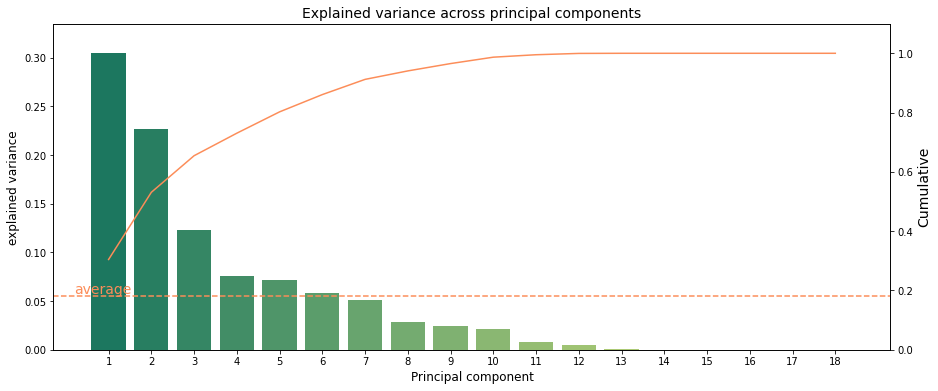

In [59]:
# Limiter le plot au nombre de composantes principales √† analyser :
limit = int(input("Limit screen plot to number of component (0 for all) > "))
if limit > 0:
    limit_df = limit
else:
    limit_df = n_components
df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]

# Affichages graphiques :
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')
ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') # plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) # label y axis
max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))
plt.show()

In [60]:
from matplotlib.ticker import PercentFormatter

def pareto(data) :
    y = list(data)
    x = range(len(data))
    ycum = np.cumsum(y)/sum(y)*100
    fig, ax = plt.subplots(figsize=(19,10))
    ax.set_title('Explication de la variance et Nbre de composantes prises en compte :', fontsize=14)
    ax.set_xlabel('Composantes principales', fontsize=12)
    ax.set_ylabel('Variance expliqu√©e', fontsize=12)
    ax.bar(x,y, color="#336635")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    
    ax2.axhline(y=80,color="orange", ls='--')
    ax2.axhline(y=99,color="r", ls='--')
    ax2.axhline(y=95,color="r", ls='--')
    ax2.text(.8, 82, "Zone de Pareto", color='#fc8d59', fontsize=14) # label y axis
    ax2.text(.8, 96, "Machine Learning : Zone de Pr√©cision Maximale", color='r', fontsize=14) # label y axis
    
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.ylim(0,110)
    plt.show()

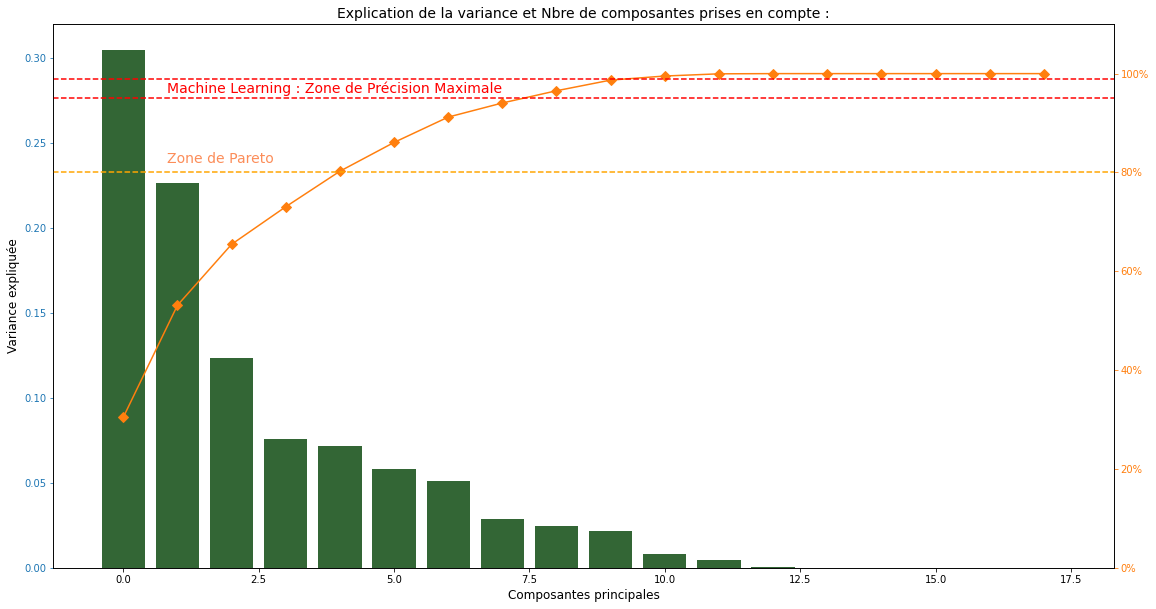

In [61]:
pareto(mypca.explained_variance_ratio_)

## En g√©n√©ral en Machine Learning nous aimons pouvoir capter entre 95% et 99% de la variance.
## J'ai trac√© deux lignes violettes sur le sch√©ma pr√©c√©dent afin de signaler notre zone de recherche optimale.
## A partir du d√©passement de la ligne rouge nos composantes expliquent plus de 80% de la variance dans le jeu de donn√©es.
---
# Avec ces informations nous pouvons construire plusieurs types de strat√©gies aussi bien pour du Machine learning de haute pr√©cision que du focus concentr√© sur les effets leviers de type Pareto (20% d'actions essentielles qui d√©clenchent 80% du CA) bref un panel de choix compl√©mentaires s'offrent √† nous.

---

---

# Approfondissement d'analyse PCA sur les 10 composantes principales :

In [99]:
train_features = X

model = PCA(n_components=10).fit(X_scaled)
X_pc = model.transform(X_scaled)
X_pc

array([[-1.97822308,  1.52562427,  0.06004776, ..., -0.43784248,
         0.14659994,  0.06376787],
       [ 2.54775247, -0.29277282,  0.47685398, ..., -1.09122175,
        -0.65376173, -0.07136197],
       [-0.52111606, -0.63267773, -0.20391309, ...,  0.15046265,
        -0.01589147, -0.18420553],
       ...,
       [14.83179225,  6.22209218, -3.0215132 , ..., -0.0493312 ,
        -0.20260366, -1.52538695],
       [-2.08577041,  1.82933535,  0.07907436, ..., -0.77427146,
         0.46793787,  0.24230619],
       [-1.93034948,  0.40034865, -0.25243994, ...,  0.96446714,
        -0.63393285, -0.49456312]])

In [100]:
# number of components
n_pcs= model.components_.shape[0]
n_pcs

10

In [101]:
# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important

[12, 17, 13, 2, 16, 15, 2, 17, 9, 13]

In [102]:
initial_feature_names = dispo_alim_complet.columns
initial_feature_names

Index(['Alimentation pour touristes', 'Aliments pour animaux',
       'Autres utilisations (non alimentaire)',
       'Disponibilit√© alimentaire (Kcal/personne/jour)',
       'Disponibilit√© alimentaire en quantit√© (kg/personne/an)',
       'Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)',
       'Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)',
       'Disponibilit√© int√©rieure', 'Exportations - Quantit√©',
       'Importations - Quantit√©', 'Nourriture', 'Pertes', 'Production',
       'R√©sidus', 'Semences', 'Traitement', 'Variation de stock',
       'population_en_milliers'],
      dtype='object')

In [103]:
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['Production',
 'population_en_milliers',
 'R√©sidus',
 'Autres utilisations (non alimentaire)',
 'Variation de stock',
 'Traitement',
 'Autres utilisations (non alimentaire)',
 'population_en_milliers',
 'Importations - Quantit√©',
 'R√©sidus']

In [104]:
# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
dic

{'PC0': 'Production',
 'PC1': 'population_en_milliers',
 'PC2': 'R√©sidus',
 'PC3': 'Autres utilisations (non alimentaire)',
 'PC4': 'Variation de stock',
 'PC5': 'Traitement',
 'PC6': 'Autres utilisations (non alimentaire)',
 'PC7': 'population_en_milliers',
 'PC8': 'Importations - Quantit√©',
 'PC9': 'R√©sidus'}

In [105]:
# build the dataframe
df = pd.DataFrame(dic.items())
df.head(3)

0                       1
0  PC0              Production
1  PC1  population_en_milliers
2  PC2                 R√©sidus

In [106]:
# Contr√¥le visuel des rapports variationnels :
X_pc.plot(figsize=(19,5))

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [107]:
X_pc = pd.DataFrame(X_pc)
X_pc = X_pc.rename(columns= {
                      0: dic['PC0'],
                      1: dic['PC1'],
                      2: dic['PC2'],
                      3: dic['PC3'], 
                      4: dic['PC4'], 
                      5: dic['PC5'], 
                      6: dic['PC6'], 
                      7: dic['PC7'], 
                      8: dic['PC8'], 
                      9: dic['PC9'],  })

In [108]:
X_pc.head(5)

Production  population_en_milliers   R√©sidus  \
0   -1.978223                1.525624  0.060048   
1    2.547752               -0.292773  0.476854   
2   -0.521116               -0.632678 -0.203913   
3   -1.504230                1.271560 -0.087120   
4    2.337507                2.000810  4.469792   

   Autres utilisations (non alimentaire)  Variation de stock  Traitement  \
0                              -0.165553           -0.110867   -0.252441   
1                               0.785779            0.869231    0.276925   
2                              -0.060953           -0.184837   -0.174762   
3                              -0.067631           -0.154388   -0.230303   
4                              -1.503266            0.420689    4.511768   

   Autres utilisations (non alimentaire)  population_en_milliers  \
0                               0.062812               -0.437842   
1                              -1.705661               -1.091222   
2                              -0.021109                0.150463   
3                              -0.023338               -0.443856   
4                              -0.043019               -0.087612   

   Importations - Quantit√©   R√©sidus  
0                 0.146600  0.063768  
1                -0.653762 -0.071362  
2                -0.015891 -0.184206  
3                 0.378312  0.134695  
4                -1.470770  0.002312

In [109]:
model.components_.shape

(10, 18)

In [110]:
np.transpose(model.components_).shape
#score=  pca.fit_transform(x)[:, components]

(18, 10)

# Fonction de visualisation Bi-Plot pour ACP :

In [121]:
# Librairies sp√©cifiques pour cercle des corr√©lations :
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.cm as cm

def biplot(pca = [], x = None, y = None,
           components = [0,1,2,3,4,5,6,7,8,9],
           score = None, coeff = None, coeff_labels = None,
           score_labels = None, circle = 'T', bigdata = 1000, cat = None, cmap = "viridis",
           density = True):

    if isinstance(pca, PCA) == True :

        coeff = np.transpose(pca.components_[components, :])

        score=  pca.fit_transform(x)[:, components]

        if isinstance(x, pd.DataFrame) == True :

            coeff_labels = list(x.columns)

    if score is not None : x = score

    if x.shape[1] > 1 :

        xs = x[:, 0]

        ys = x[:, 1]

    else :

        xs = x

        ys = y

    if (len(xs) != len(ys)) : print("Warning ! x et y n'ont pas la m√™me taille !")

    scalex = 1.0 / (xs.max() - xs.min())

    scaley = 1.0 / (ys.max() - ys.min())

    #x_c = xs * scalex
    #y_c = ys * scaley

    temp = (xs - xs.min())

    x_c = temp / temp.max() * 2 - 1

    temp = (ys - ys.min())

    y_c = temp / temp.max() * 2 - 1

    data = pd.DataFrame({"x_c" : x_c, "y_c" : y_c})

    print("Attention : pour des facilit√©s d'affichage, les donn√©es sont centr√©es-r√©duites")

    if cat is None : cat = [0]*len(xs)

    elif len(pd.Series(cat)) == 1 : cat = list(pd.Series(cat)) * len(xs)

    elif len(pd.Series(cat)) != len(xs) : print("Warning ! Nombre anormal de cat√©gories !")

    cat = pd.Series(cat).astype("category")

    fig = plt.figure(figsize = (16, 16), facecolor = 'w') 

    ax = fig.add_subplot(111)

    # Affichage des points

    if (len(xs) < bigdata) :   

        ax.scatter(x_c, y_c, c = cat.cat.codes, cmap = cmap)

        if density == True : print("Warning ! Le mode density actif n'apparait que si BigData est param√©tr√©.")

    # Affichage des nappes convexes (BigData)

    else :

        #color

        norm = mpl.colors.Normalize(vmin = 0, vmax = (len(np.unique(cat.cat.codes)))) #-(len(np.unique(c)))

        cmap = cmap

        m = cm.ScalarMappable(norm = norm, cmap = cmap)

        if density == True :

            sns.set_style("white")

            sns.kdeplot(x = "x_c", y = "y_c", data = data)

            if len(np.unique(cat)) <= 1 :

                sns.kdeplot(x = "x_c", y = "y_c", data = data, cmap = "Blues", shade = True, thresh = 0)

            else :

                for i in np.unique(cat) :

                    color_temp = m.to_rgba(i)

                    sns.kdeplot(x = "x_c", y = "y_c", data = data[cat==i], color = color_temp,

                                shade = True, thresh = 0.25, alpha = 0.25)     

        for cat_temp in cat.cat.codes.unique() :

            x_c_temp = [x_c[i] for i in range(len(x_c)) if (cat.cat.codes[i] == cat_temp)]

            y_c_temp = [y_c[i] for i in range(len(y_c)) if (cat.cat.codes[i] == cat_temp)]

            points = [ [ None ] * len(x_c_temp) ] * 2

            points = np.array(points)

            points = points.reshape(len(x_c_temp), 2)

            points[:, 0] = x_c_temp

            points[:, 1] = y_c_temp

            hull = ConvexHull(points)

            temp = 0

            for simplex in hull.simplices:

                color_temp = m.to_rgba(cat_temp)

                plt.plot(points[simplex, 0], points[simplex, 1], color = color_temp) #, linestyle='dashed')#linewidth=2,color=cat)

                if (temp == 0) :

                     plt.xlim(-1, 1)

                     plt.ylim(-1, 1)

                     temp = temp + 1

    if coeff is not None :

        if (circle == 'T') :

            x_circle = np.linspace(-1, 1, 100)

            y_circle = np.linspace(-1, 1, 100)

            X, Y = np.meshgrid(x_circle, y_circle)

            F = X**2 + Y**2 - 1.0

            #fig, ax = plt.subplots()

            plt.contour(X, Y, F, [0])

        n = coeff.shape[0]

        for i in range(n):

            plt.arrow(0, 0, coeff[i, 0], coeff[i, 1],color = 'r',alpha = 0.5,

                      head_width = 0.05, head_length = 0.05)

            if coeff_labels is None:

                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color = 'g',
                         ha = 'center', va = 'center')

            else:

                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, coeff_labels[i], color = 'g', ha = 'center',
                         va = 'center')

        if score_labels is not None :

            for i in range(len(score_labels)) :

                temp_x = xs[i] * scalex

                temp_y = ys[i] * scaley

                plt.text(temp_x, temp_y,list(score_labels)[i])

    plt.xlim(-1.2,1.2)

    plt.ylim(-1.2,1.2)

    plt.xlabel("PC{}".format(1))

    plt.ylabel("PC{}".format(2))

    plt.grid(linestyle='--')

    plt.show()

In [122]:
model.explained_variance_ratio_

array([0.30461986, 0.22659451, 0.12337201, 0.07597586, 0.07191637,
       0.05825658, 0.0512892 , 0.02854826, 0.02475998, 0.0215489 ])

---

In [123]:
model.explained_variance_ # composantes tri√©es par variance expliqu√©e

array([4.90275746, 3.6469649 , 1.98563236, 1.22280678, 1.15747062,
       0.9376207 , 0.825483  , 0.45947499, 0.39850374, 0.34682254])

---

In [135]:
from sklearn.decomposition import PCA

mypca = PCA(n_components=10) # On param√®tre ici pour ne garder que 3 composantes

# Mod√®le d'ACP

mypca.fit(X)

# Pourcentage de la variance expliqu√©e par chacune des composantes s√©lectionn√©es.

print(mypca.singular_values_) # Valeurs de variance

print(mypca.explained_variance_ratio_) #  Pourcentages

# Axes principaux dans l'espace des caract√©ristiques, repr√©sentant les directions de la variance maximale dans les donn√©es. Les composantes sont tri√©es par variance expliqu√©e.

print(mypca.components_) # 

# R√©sultats de l'ACP

data_sortie_10= mypca.fit_transform(X)

# Bruit estim√© li√© √† la covariance

print(mypca.noise_variance_)

[28.70003646 24.75301104 18.26466308 14.33313408 13.94495871 12.55092797
 11.776502    8.78604011  8.18235741  7.63336278]
[0.30461986 0.22659451 0.12337201 0.07597586 0.07191637 0.05825658
 0.0512892  0.02854826 0.02475998 0.0215489 ]
[[-5.76577694e-02 -0.00000000e+00  5.88874389e-02  3.34389181e-01
   3.24416449e-01  3.30805927e-01  3.24924944e-01  3.54058636e-01
   3.16005400e-01  1.78399622e-01  3.54835052e-01  1.35801217e-01
   3.58017511e-01 -1.03331289e-01 -0.00000000e+00  1.05088190e-01
   5.40438053e-02  8.32197089e-02]
 [-3.45141824e-02  1.38777878e-17  3.94736640e-02 -3.47744784e-01
  -3.56803336e-01 -3.36699531e-01 -3.48796244e-01  2.91771576e-01
   1.63581112e-01  7.85175259e-02  2.86254508e-01  2.54956953e-01
   2.81250088e-01  2.62563291e-03 -3.08148791e-33  1.29813704e-01
   1.16759083e-02  3.91017384e-01]
 [-5.35538999e-01 -1.11022302e-16 -5.37661965e-02 -3.14699786e-02
  -2.56308991e-02 -6.62650760e-02  2.41465175e-02 -1.52358249e-01
   2.52262995e-02  4.28800630e-01 

In [136]:
X

Alimentation pour touristes  Aliments pour animaux  \
zone                                                                        
Afghanistan                              -0.061605                    0.0   
Afrique du Sud                           -0.061605                    0.0   
Albanie                                  -0.061605                    0.0   
Alg√©rie                                  -0.061605                    0.0   
Allemagne                                -0.061605                    0.0   
...                                            ...                    ...   
√âmirats arabes unis                      -0.061605                    0.0   
√âquateur                                 -0.061605                    0.0   
√âtats-Unis d'Am√©rique                    -0.061605                    0.0   
√âthiopie                                 -0.061605                    0.0   
√éles Salomon                             -0.061605                    0.0   

                       Autres utilisations (non alimentaire)  \
zone                                                           
Afghanistan                                        -0.134956   
Afrique du Sud                                     -0.134956   
Albanie                                            -0.134956   
Alg√©rie                                            -0.134956   
Allemagne                                          -0.134956   
...                                                      ...   
√âmirats arabes unis                                -0.134956   
√âquateur                                           -0.134956   
√âtats-Unis d'Am√©rique                               1.226297   
√âthiopie                                           -0.134956   
√éles Salomon                                       -0.134956   

                       Disponibilit√© alimentaire (Kcal/personne/jour)  \
zone                                                                    
Afghanistan                                                 -1.156933   
Afrique du Sud                                               1.118715   
Albanie                                                      0.162283   
Alg√©rie                                                     -0.876600   
Allemagne                                                   -0.068580   
...                                                               ...   
√âmirats arabes unis                                          1.184676   
√âquateur                                                     0.129303   
√âtats-Unis d'Am√©rique                                        2.371970   
√âthiopie                                                    -1.239384   
√éles Salomon                                                -0.942561   

                       Disponibilit√© alimentaire en quantit√© (kg/personne/an)  \
zone                                                                            
Afghanistan                                                    -1.187115        
Afrique du Sud                                                  0.964693        
Albanie                                                        -0.252943        
Alg√©rie                                                        -0.881603        
Allemagne                                                      -0.057037        
...                                                                  ...        
√âmirats arabes unis                                             1.454772        
√âquateur                                                       -0.067116        
√âtats-Unis d'Am√©rique                                           2.223904        
√âthiopie                                                       -1.275304        
√éles Salomon                                                   -1.003178        

                       Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)  \
zone                                                          

In [137]:
data_sortie_10_df = pd.DataFrame(data_sortie_10)
data_sortie_10_df = data_sortie_10_df.rename(columns= {
                      0: dic['PC0'],
                      1: dic['PC1'],
                      2: dic['PC2'],
                      3: dic['PC3'], 
                      4: dic['PC4'], 
                      5: dic['PC5'], 
                      6: dic['PC6'], 
                      7: dic['PC7'], 
                      8: dic['PC8'], 
                      9: dic['PC9'],  })

In [138]:
data_sortie_10_df

Production  population_en_milliers   R√©sidus  \
0     -1.972396                1.521131  0.059871   
1      2.540248               -0.291910  0.475449   
2     -0.519581               -0.630814 -0.203312   
3     -1.499799                1.267815 -0.086863   
4      2.330622                1.994917  4.456626   
..          ...                     ...       ...   
165    1.687665               -1.816565  0.596481   
166   -0.279354               -0.166332 -0.280295   
167   14.788105                6.203765 -3.012613   
168   -2.079627                1.823947  0.078841   
169   -1.924664                0.399169 -0.251696   

     Autres utilisations (non alimentaire)  Variation de stock  Traitement  \
0                                -0.165065           -0.110541   -0.251698   
1                                 0.783465            0.866671    0.276109   
2                                -0.060774           -0.184292   -0.174248   
3                                -0.067432           -0.153933   -0.229625   
4                                -1.498838            0.419450    4.498478   
..                                     ...                 ...         ...   
165                               0.291365            0.417524    0.370698   
166                               0.081461           -0.191818   -0.119963   
167                              -3.524696           -1.037790   -1.256759   
168                              -0.159679           -0.081634   -0.240895   
169                              -0.284610           -0.438998   -0.386846   

     Autres utilisations (non alimentaire)  population_en_milliers  \
0                                 0.062627               -0.436553   
1                                -1.700637               -1.088008   
2                                -0.021047                0.150019   
3                                -0.023270               -0.442549   
4                                -0.042892               -0.087354   
..                                     ...                     ...   
165                              -1.067056               -1.177701   
166                              -0.191109               -0.337664   
167                               3.556226               -0.049186   
168                               0.063180               -0.771991   
169                               0.350028                0.961626   

     Importations - Quantit√©   R√©sidus  
0                   0.146168  0.063580  
1                  -0.651836 -0.071152  
2                  -0.015845 -0.183663  
3                   0.377197  0.134298  
4                  -1.466437  0.002306  
..                       ...       ...  
165                -0.838981 -0.241398  
166                 0.525044  0.114281  
167                -0.202007 -1.520894  
168                 0.466560  0.241592  
169                -0.632066 -0.493106  

[170 rows x 10 columns]

In [139]:
X = pd.DataFrame(X)

---

# Projection d'un bi-plot sur les 10 composantes principales :

Attention : pour des facilit√©s d'affichage, les donn√©es sont centr√©es-r√©duites
Warning ! Le mode density actif n'apparait que si BigData est param√©tr√©.


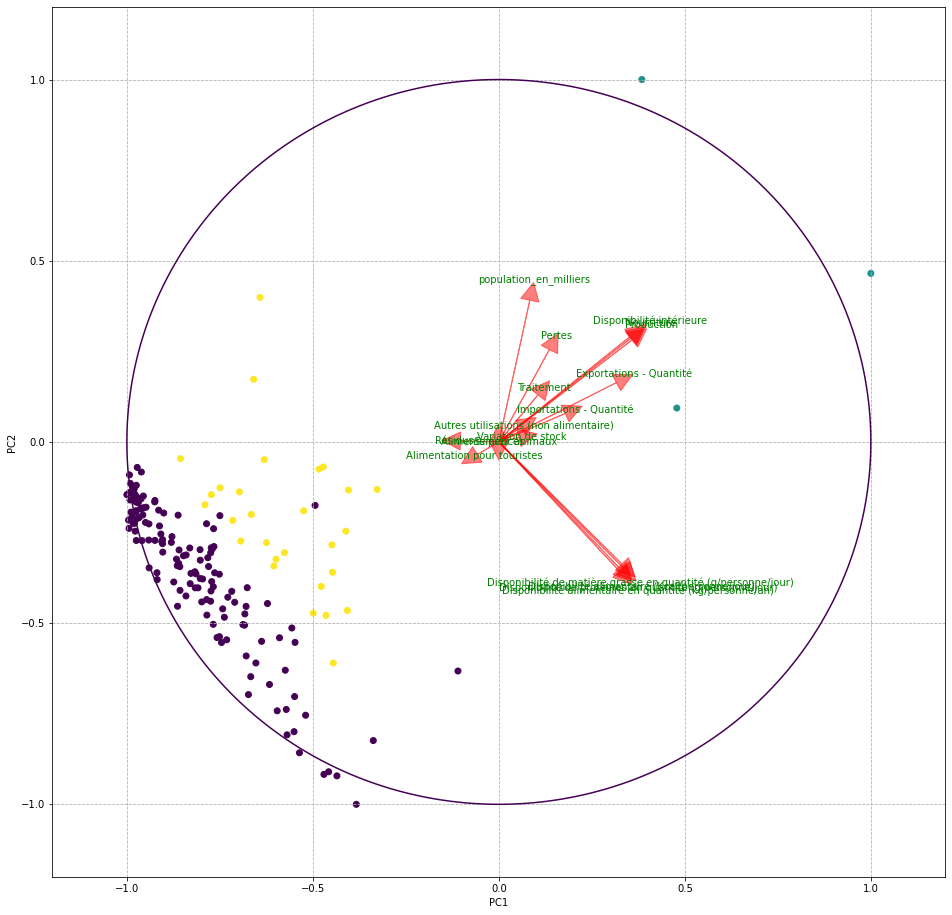

In [130]:
biplot(mypca,
       x=X,
       cat=y_cluster_predict_kmean,
       components=[0,1,2,3,4,5,6,7,8,9],
       coeff_labels = list(X.columns),
      )

plt.show()

## Autres analyses Bi-plot :

Attention : pour des facilit√©s d'affichage, les donn√©es sont centr√©es-r√©duites
Warning ! Le mode density actif n'apparait que si BigData est param√©tr√©.


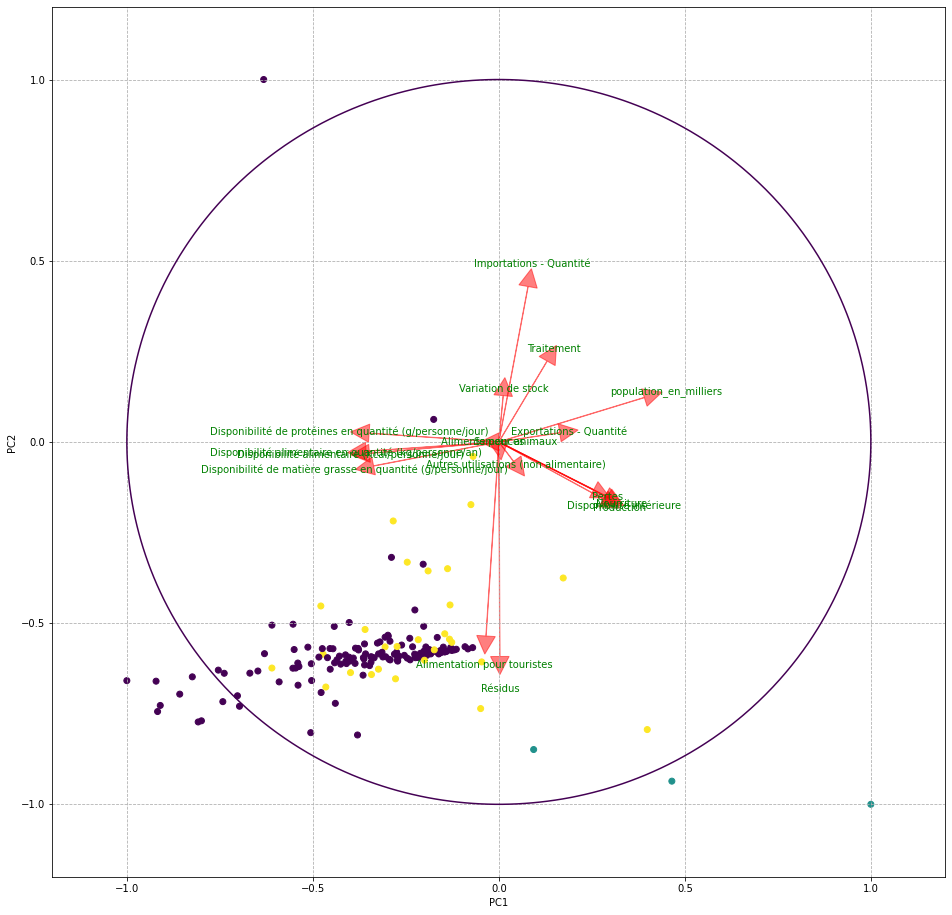

In [147]:
biplot(pca = model,
       x = X,
       cat = y_cluster_predict_kmean,
       components = [1,2], # Visualisation des composantes 9 et 12 √† titre d'exemple
       #cmap = "Paired",
      )
plt.show()

# Les variables Production et population_en_milliers ont un poids extr√™me dans la classification synth√©tique de nos donn√©es.

---

## Analyse avec nos 10 composantes principales et visualisation des clusters :

In [148]:
X_pc.shape

(170, 10)

In [149]:
X_pc = np.array(X_pc)

In [150]:
model.components_[0:10, :].shape

(10, 18)

In [151]:
data_sortie[:, 0:10].shape

(170, 10)

Attention : pour des facilit√©s d'affichage, les donn√©es sont centr√©es-r√©duites


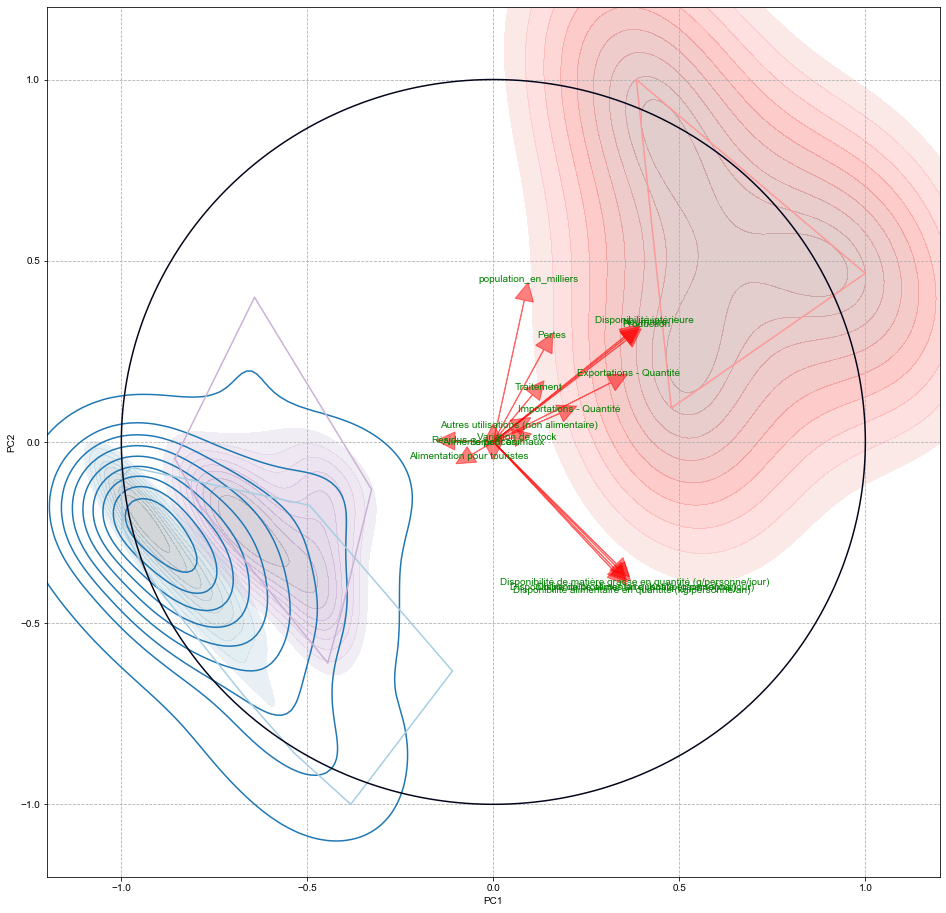

In [152]:
biplot(score = data_sortie[:, 0:10],

    coeff=np.transpose(mypca.components_[0:10, :]), # de forme : pca.components_[components, :]
       cat=y_cluster_predict_kmean,
       bigdata = 100,
       coeff_labels = list(X.columns),
       density= True,
       cmap = "Paired")

plt.show()

In [290]:
############### DEFINE PARAMS
top_k = 10
#select data based on percentile (top_q) or top-k features
top_q = .50
top_pc = 10
###############

# PCA factor loadings
df_c = pd.DataFrame(model.components_).T

print("Factor Loadings for the 1. component \n(explains {0:.2f} of the variance)".format(df_explained_variance.iloc[0,0]))
print('='*40,'\n')
print('Top {} highest'.format(top_k))
print('-'*40)
print(df_c.iloc[:,0].sort_values(ascending=False)[:top_k], '\n')

print('Top {} lowest'.format(top_k))
print('-'*40)
print(df_c.iloc[:,0].sort_values()[:top_k])

Factor Loadings for the 1. component 
(explains 0.30 of the variance)

Top 10 highest
----------------------------------------
12    0.358018
10    0.354835
7     0.354059
3     0.334389
5     0.330806
6     0.324925
4     0.324416
8     0.316005
9     0.178400
11    0.135801
Name: 0, dtype: float64 

Top 10 lowest
----------------------------------------
13   -0.103331
0    -0.057658
1    -0.000000
14   -0.000000
16    0.054044
2     0.058887
17    0.083220
15    0.105088
11    0.135801
9     0.178400
Name: 0, dtype: float64


In [295]:
df_c.index = X.columns

In [303]:
df_c.iloc[:,0]

Alimentation pour touristes                                     -0.057658
Aliments pour animaux                                           -0.000000
Autres utilisations (non alimentaire)                            0.058887
Disponibilit√© alimentaire (Kcal/personne/jour)                   0.334389
Disponibilit√© alimentaire en quantit√© (kg/personne/an)           0.324416
Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)    0.330806
Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)         0.324925
Disponibilit√© int√©rieure                                         0.354059
Exportations - Quantit√©                                          0.316005
Importations - Quantit√©                                          0.178400
Nourriture                                                       0.354835
Pertes                                                           0.135801
Production                                                       0.358018
R√©sidus                 

In [306]:
df_c

0             1  \
Alimentation pour touristes                        -0.057658 -3.451418e-02   
Aliments pour animaux                              -0.000000  1.387779e-17   
Autres utilisations (non alimentaire)               0.058887  3.947366e-02   
Disponibilit√© alimentaire (Kcal/personne/jour)      0.334389 -3.477448e-01   
Disponibilit√© alimentaire en quantit√© (kg/perso...  0.324416 -3.568033e-01   
Disponibilit√© de mati√®re grasse en quantit√© (g/...  0.330806 -3.366995e-01   
Disponibilit√© de prot√©ines en quantit√© (g/perso...  0.324925 -3.487962e-01   
Disponibilit√© int√©rieure                            0.354059  2.917716e-01   
Exportations - Quantit√©                             0.316005  1.635811e-01   
Importations - Quantit√©                             0.178400  7.851753e-02   
Nourriture                                          0.354835  2.862545e-01   
Pertes                                              0.135801  2.549570e-01   
Production                                          0.358018  2.812501e-01   
R√©sidus                                            -0.103331  2.625633e-03   
Semences                                           -0.000000 -3.081488e-33   
Traitement                                          0.105088  1.298137e-01   
Variation de stock                                  0.054044  1.167591e-02   
population_en_milliers                              0.083220  3.910174e-01   

                                                               2  \
Alimentation pour touristes                        -5.355390e-01   
Aliments pour animaux                              -1.110223e-16   
Autres utilisations (non alimentaire)              -5.376620e-02   
Disponibilit√© alimentaire (Kcal/personne/jour)     -3.146998e-02   
Disponibilit√© alimentaire en quantit√© (kg/perso... -2.563090e-02   
Disponibilit√© de mati√®re grasse en quantit√© (g/... -6.626508e-02   
Disponibilit√© de prot√©ines en quantit√© (g/perso...  2.414652e-02   
Disponibilit√© int√©rieure                           -1.523582e-01   
Exportations - Quantit√©                             2.522630e-02   
Importations - Quantit√©                             4.288006e-01   
Nourriture                                         -1.486003e-01   
Pertes                                             -1.318040e-01   
Production                                         -1.575951e-01   
R√©sidus                                            -5.920895e-01   
Semences                                           -0.000000e+00   
Traitement                                          2.231651e-01   
Variation de stock                                  1.277110e-01   
population_en_milliers                              1.224465e-01   

                                                               3  \
Alimentation pour touristes                        -1.841046e-01   
Aliments pour animaux                              -3.469447e-17   
Autres utilisations (non alimentaire)               6.834506e-01   
Disponibilit√© alimentaire (Kcal/personne/jour)      4.340812e-02   
Disponibilit√© alimentaire en quantit√© (kg/perso...  3.798547e-02   
Disponibilit√© de mati√®re grasse en quantit√© (g/...  3.506070e-02   
Disponibilit√© de prot√©ines en quantit√© (g/perso...  5.471068e-02   
Disponibilit√© int√©rieure                           -3.329212e-02   
Exportations - Quantit√©                            -3.177903e-01   
Importations - Quantit√©                             7.278099e-02   
Nourriture                                         -7.096728e-02   
Pertes                                              5.433825e-01   
Production                                         -9.560972e-02   
R√©sidus                                            -2.891284e-02   
Semences                                            2.584939e-26   
Traitement                                         -2.550649e-01   
Variation de stock                                 -6.843637e-02   
population_en_mil

In [311]:
df_c.iloc[:,0].sort_values(ascending=False)
# print(df_c.iloc[:,0].sort_values(ascending=False)[:top_k], '\n')

Production                                                       0.358018
Nourriture                                                       0.354835
Disponibilit√© int√©rieure                                         0.354059
Disponibilit√© alimentaire (Kcal/personne/jour)                   0.334389
Disponibilit√© de mati√®re grasse en quantit√© (g/personne/jour)    0.330806
Disponibilit√© de prot√©ines en quantit√© (g/personne/jour)         0.324925
Disponibilit√© alimentaire en quantit√© (kg/personne/an)           0.324416
Exportations - Quantit√©                                          0.316005
Importations - Quantit√©                                          0.178400
Pertes                                                           0.135801
Traitement                                                       0.105088
population_en_milliers                                           0.083220
Autres utilisations (non alimentaire)                            0.058887
Variation de stock       

In [300]:
df_columns = format(top_k)

In [301]:
df_columns

'10'

### Liens entre les composantes et nos variables :

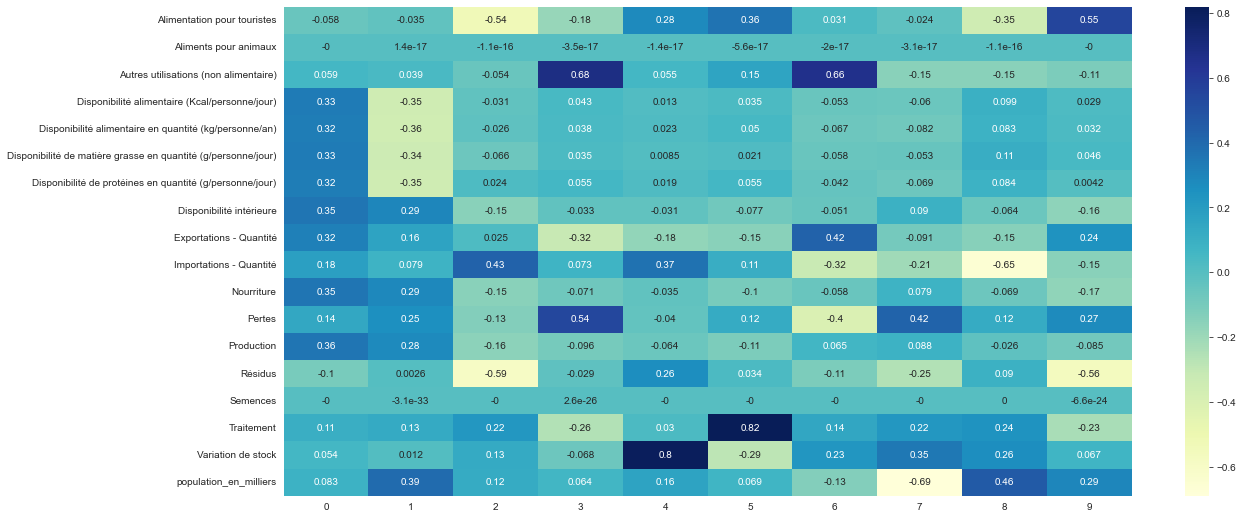

In [320]:
# adjust y-axis size dynamically
size_yaxis = round(X.shape[1] * 0.5)
fig, ax = plt.subplots(figsize=(19,size_yaxis))
# plot the first top_pc components
top_pc = 10
sns.heatmap(df_c.iloc[:,:top_pc], annot=True, cmap="YlGnBu", ax=ax)
plt.show()


In [316]:
model.components_

array([[-5.76577694e-02, -0.00000000e+00,  5.88874389e-02,
         3.34389181e-01,  3.24416449e-01,  3.30805927e-01,
         3.24924944e-01,  3.54058636e-01,  3.16005400e-01,
         1.78399622e-01,  3.54835052e-01,  1.35801217e-01,
         3.58017511e-01, -1.03331289e-01, -0.00000000e+00,
         1.05088190e-01,  5.40438053e-02,  8.32197089e-02],
       [-3.45141824e-02,  1.38777878e-17,  3.94736640e-02,
        -3.47744784e-01, -3.56803336e-01, -3.36699531e-01,
        -3.48796244e-01,  2.91771576e-01,  1.63581112e-01,
         7.85175259e-02,  2.86254508e-01,  2.54956953e-01,
         2.81250088e-01,  2.62563291e-03, -3.08148791e-33,
         1.29813704e-01,  1.16759083e-02,  3.91017384e-01],
       [-5.35538999e-01, -1.11022302e-16, -5.37661965e-02,
        -3.14699786e-02, -2.56308991e-02, -6.62650760e-02,
         2.41465175e-02, -1.52358249e-01,  2.52262995e-02,
         4.28800630e-01, -1.48600283e-01, -1.31803959e-01,
        -1.57595133e-01, -5.92089460e-01, -0.00000000e

In [219]:
df_c

Alimentation pour touristes  Aliments pour animaux  \
0                     -0.057658          -3.451418e-02   
1                     -0.000000           1.387779e-17   
2                      0.058887           3.947366e-02   
3                      0.334389          -3.477448e-01   
4                      0.324416          -3.568033e-01   
5                      0.330806          -3.366995e-01   
6                      0.324925          -3.487962e-01   
7                      0.354059           2.917716e-01   
8                      0.316005           1.635811e-01   
9                      0.178400           7.851753e-02   
10                     0.354835           2.862545e-01   
11                     0.135801           2.549570e-01   
12                     0.358018           2.812501e-01   
13                    -0.103331           2.625633e-03   
14                    -0.000000          -3.081488e-33   
15                     0.105088           1.298137e-01   
16                     0.054044           1.167591e-02   
17                     0.083220           3.910174e-01   

    Autres utilisations (non alimentaire)  \
0                           -5.355390e-01   
1                           -1.110223e-16   
2                           -5.376620e-02   
3                           -3.146998e-02   
4                           -2.563090e-02   
5                           -6.626508e-02   
6                            2.414652e-02   
7                           -1.523582e-01   
8                            2.522630e-02   
9                            4.288006e-01   
10                          -1.486003e-01   
11                          -1.318040e-01   
12                          -1.575951e-01   
13                          -5.920895e-01   
14                          -0.000000e+00   
15                           2.231651e-01   
16                           1.277110e-01   
17                           1.224465e-01   

    Disponibilit√© alimentaire (Kcal/personne/jour)  \
0                                    -1.841046e-01   
1                                    -3.469447e-17   
2                                     6.834506e-01   
3                                     4.340812e-02   
4                                     3.798547e-02   
5                                     3.506070e-02   
6                                     5.471068e-02   
7                                    -3.329212e-02   
8                                    -3.177903e-01   
9                                     7.278099e-02   
10                                   -7.096728e-02   
11                                    5.433825e-01   
12                                   -9.560972e-02   
13                                   -2.891284e-02   
14                                    2.584939e-26   
15                                   -2.550649e-01   
16                                   -6.843637e-02   
17                                    6.352369e-02   

    Disponibilit√© alimentaire en quantit√© (kg/personne/an)  \
0                                        2.781900e-01        
1                                       -1.387779e-17        
2                                        5.509770e-02        
3                                        1.318817e-02        
4                                        2.291552e-02        
5                                        8.485116e-03        
6                                        1.929298e-02        
7                                       -3.135606e-02        
8                                       -1.756915e-01        
9                                        3.712914e-01        
10                                      -3.461806e-02        
11                                      -3.951982e-02        
12                                      -6.367241e-02        
13                                       2.632340e-01        
14                                      -0.000000e+00        
15                     

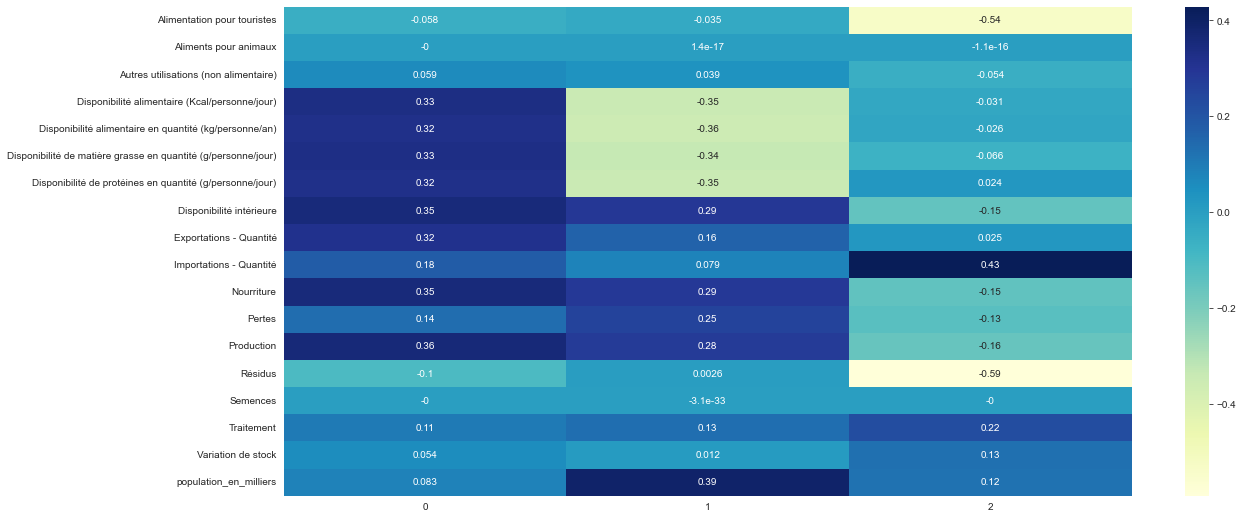

In [317]:
# adjust y-axis size dynamically
size_yaxis = round(X.shape[1] * 0.5)
fig, ax = plt.subplots(figsize=(19,size_yaxis))
# plot the first top_pc components
top_pc = 3
sns.heatmap(df_c.iloc[:,:top_pc], annot=True, cmap="YlGnBu", ax=ax)
plt.show()

# Conclusions :

In [119]:
## Nous avons donc 3 clusters qui apparaissent assez √©vidents.
# Le premier cluster sera compos√© d'√Æles et de pays plut√¥t pauvre avec une faible production de volaille qui importent des quantit√©s plut√¥t faibles.
# Le second cluster sera compos√© de gros producteurs, gros exportateurs, ce sont des pays riches.
# Le 3√®me cluster est compos√© de pays qui importent beaucoup (en g√©n√©ral), qui vendent aussi mais sans √™tre grossistes.

In [ ]:
# Conseil : Approfondir l'analyse avec davantage de variables plus int√©ressantes.